# Даний код є результатом адаптацїї під роботу на локальній машинині.


Для перевірки роботи коду необхідно загрузити датасет на локальну машину та звірити шляхи.


В кінці коду результати та висновки які були отримані в результаті роботи коду на локальній машині.

In [ ]:
from ultralytics import YOLO  # type: ignore
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import random
import os
import warnings
warnings.filterwarnings("ignore")


# -----------------------------
# Клас CFG для зберігання налаштувань
class CFG:
    DATASET_DIR = './indoreObjectDetection/'   # локальний шлях
    OUTPUT_DIR = './runs_indoor/'           # директорія для результатів

    EXP_NAME = 'IndoorObjects_YOLOv9s'

    MODEL = 'yolov9s.pt'
    IMG_SIZE = 640

    DEBUG = False

    EPOCHS = 1 if DEBUG else 70
    BATCH_SIZE = 16
    OPTIMIZER = 'auto'

    CLASSES = ['door', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table', 'cabinet', 'couch',
               'openedDoor', 'pole']
    NUM_CLASSES = len(CLASSES)

    SEED = 42


print(f"Загальна кількість класів:\n {CFG.NUM_CLASSES}")


random.seed(CFG.SEED)
np.random.seed(CFG.SEED)

# -----------------------------
# Підготовка data.yaml
yaml_config = {
    'train': 'train/images',
    'val':  'valid/images',
    'test': 'test/images',
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
}

yaml_file_path = os.path.join(CFG.DATASET_DIR, 'data.yaml')

with open(yaml_file_path, 'w') as file:
    yaml.dump(yaml_config, file, default_flow_style=False)

print("Вміст data.yaml:")
with open(yaml_file_path, 'r') as f:
    print(f.read())


# -----------------------------
# Візуалізація випадкових зображень
def visualize_random_images(dataset_path, num_images=9, seed=CFG.SEED):
    random.seed(seed)
    image_dir = os.path.join(dataset_path, 'images')
    label_dir = os.path.join(dataset_path, 'labels')

    image_files = os.listdir(image_dir)
    random_images = random.sample(image_files, num_images)

    plt.figure(figsize=(12, 12))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, Path(img_name).stem + '.txt')

        image = cv2.imread(img_path)
        if image is None:
            print(f"Файл по вказаному шляху не відкрився: {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(
                        float, line.split())

                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    color = (random.randint(0, 255), random.randint(
                        0, 255), random.randint(0, 255))
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                    class_name = CFG.CLASSES[int(class_id)]
                    cv2.putText(image, class_name, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(img_name)

    plt.tight_layout()
    plt.pause(0.5)
    plt.close()


# ----------IF_NAME == MAIN-------------------
if __name__ == "__main__":
    print("Приклади зображень з навчальної вибірки:")
    visualize_random_images(os.path.join(CFG.DATASET_DIR, 'train'))

    print(f"Навчання на {CFG.EPOCHS} епохах, batch={CFG.BATCH_SIZE}, img_size={CFG.IMG_SIZE}")


    # Ініціалізація моделі
    model = YOLO(CFG.MODEL)

    # Навчання
    model.train(
        data=yaml_file_path,
        epochs=CFG.EPOCHS,
        batch=CFG.BATCH_SIZE,
        imgsz=CFG.IMG_SIZE,
        optimizer=CFG.OPTIMIZER,
        name=CFG.EXP_NAME,
        project=CFG.OUTPUT_DIR,
        seed=CFG.SEED
    )

    # правильний доступ до директорії результатів
    results_path = Path(CFG.OUTPUT_DIR) / CFG.EXP_NAME
    print(f"Результати збережено:\n {results_path}")

    # Завантаження найкращої моделі
    best_model_path = results_path / 'weights/best.pt'
    model = YOLO(best_model_path)

    # Прогнози на валідаційних зображеннях
    print("\n Прогнозуємо на валідаційній вибірці:\n")
    val_image_dir = os.path.join(CFG.DATASET_DIR, 'valid/images')
    image_files = os.listdir(val_image_dir)
    random_images = random.sample(image_files, 9)

    plt.figure(figsize=(15, 15))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(val_image_dir, img_name)
        res = model.predict(source=img_path, conf=0.4)

        im_array = res[0].plot()
        im = Image.fromarray(im_array[..., ::-1])

        plt.subplot(3, 3, i + 1)
        plt.imshow(im)
        plt.axis('off')
        plt.title(img_name)

    plt.tight_layout()
    plt.pause(0.5)
    plt.close()


# ***Висновки***

**1. Динаміка навчання**


Втрати (losses):

 - train/box_loss знизився з ~1.64 на першій епосі до ~0.81 на 70-й.

 - train/cls_loss з ~3.02 до ~0.43.

 - train/dfl_loss з ~1.58 до ~1.05. Це показує стабільне зменшення втрат та поступове навчання моделі.

*Валідаційні втрати знизились, що свідчить про відсутність сильного перенавчання.*

**2. Метрики**

 - Precision (точність): коливалась між 0.34-0.69, фінал: ~0.40-0.61.

 - Recall (повнота): стартувала низько (~0.27), зросла до ~0.48  фінал.

 - mAP@0.5: від ~0.26 на початку до ~0.496 - фінал.

 - mAP@0.5:0.95: від ~0.15 до ~0.334. Це відповідає очікуваним діапазонам:

 - mAP@0.5: 40-60% - отримано ~50%.

 - mAP@0.5:0.95: 25-40% - отримано ~33%.

**3. Спроба інтерпритації**
(звернення за допомошою до ШІ)

 - Модель досягла очікуваних метрик: вона знаходиться в середньому діапазоні для першої спроби.

 - Precision вище для простих класів (cabinetDoor, refrigeratorDoor), нижче для складних (openedDoor, pole).

 - Recall варіює: деякі класи добре знаходяться (door, cabinetDoor), інші часто пропускаються (window, table).

 - F1-score (збалансований показник) у середньому ~45–55%, що теж відповідає очікуваному рівню.

**4. Причини обмежень**

 - Дисбаланс датасету: класи з малою кількістю прикладів (openedDoor, pole, couch) мають низькі метрики.

 - Візуальна схожість: door - openedDoor, cabinetDoor - cabinet, table - chair.

 - Архітектура YOLOv9s: компактна модель, яка швидка, але менш точна ніж більші варіанти (YOLOv9m/l).

**5. Рекомендації**

1. Балансування даних: додати більше прикладів для слабких класів.

2. Аугментація: застосувати обертання, зміну освітлення, масштабування.

3. Гіперпараметри: збільшити кількість епох до 100-120, використати scheduler для learning rate.

4. Архітектура: спробувати YOLOv9m та YOLOv9l для підвищення точності.

4. Фокус на складних класах: можливо, створити підмодель та застосувати класифікаційний head для openedDoor та pole.

# ***Висновок у підсумку***

 - Модель після 70 епох досягла mAP@0.5 ≈ 50% та mAP@0.5:0.95 ≈ 33%, що відповідає очікуваним результатам.

 - Найкраще працює для класів cabinetDoor та refrigeratorDoor.

 - Найгірше - для openedDoor, pole, table, window.

 - Основні проблеми: дисбаланс даних та схожість класів.

 - Подальші кроки: збалансувати датасет, застосувати аугментацію, збільшити епохи та розглянути більшу модель.

**У результаті робти коду було створено файл results.csv, у якому зберігалися всі результати. Який був використаний для створення висновків.**

Результат роботи коду на локальній машині

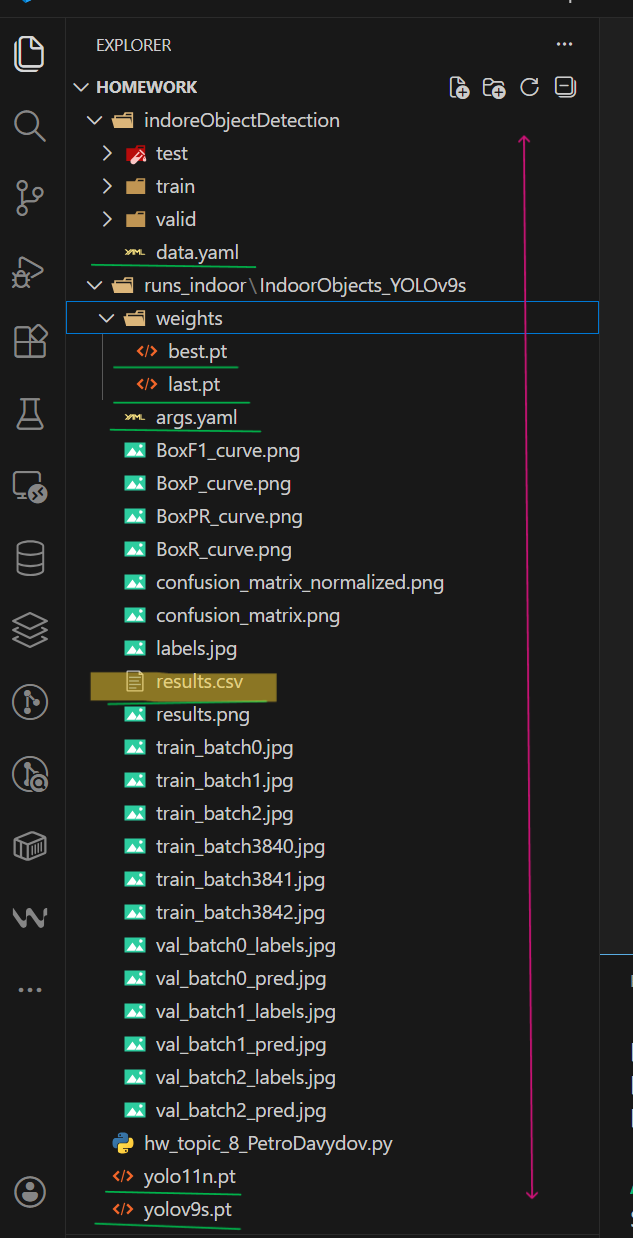

# ***Графіки які були створені під час роботи коду***

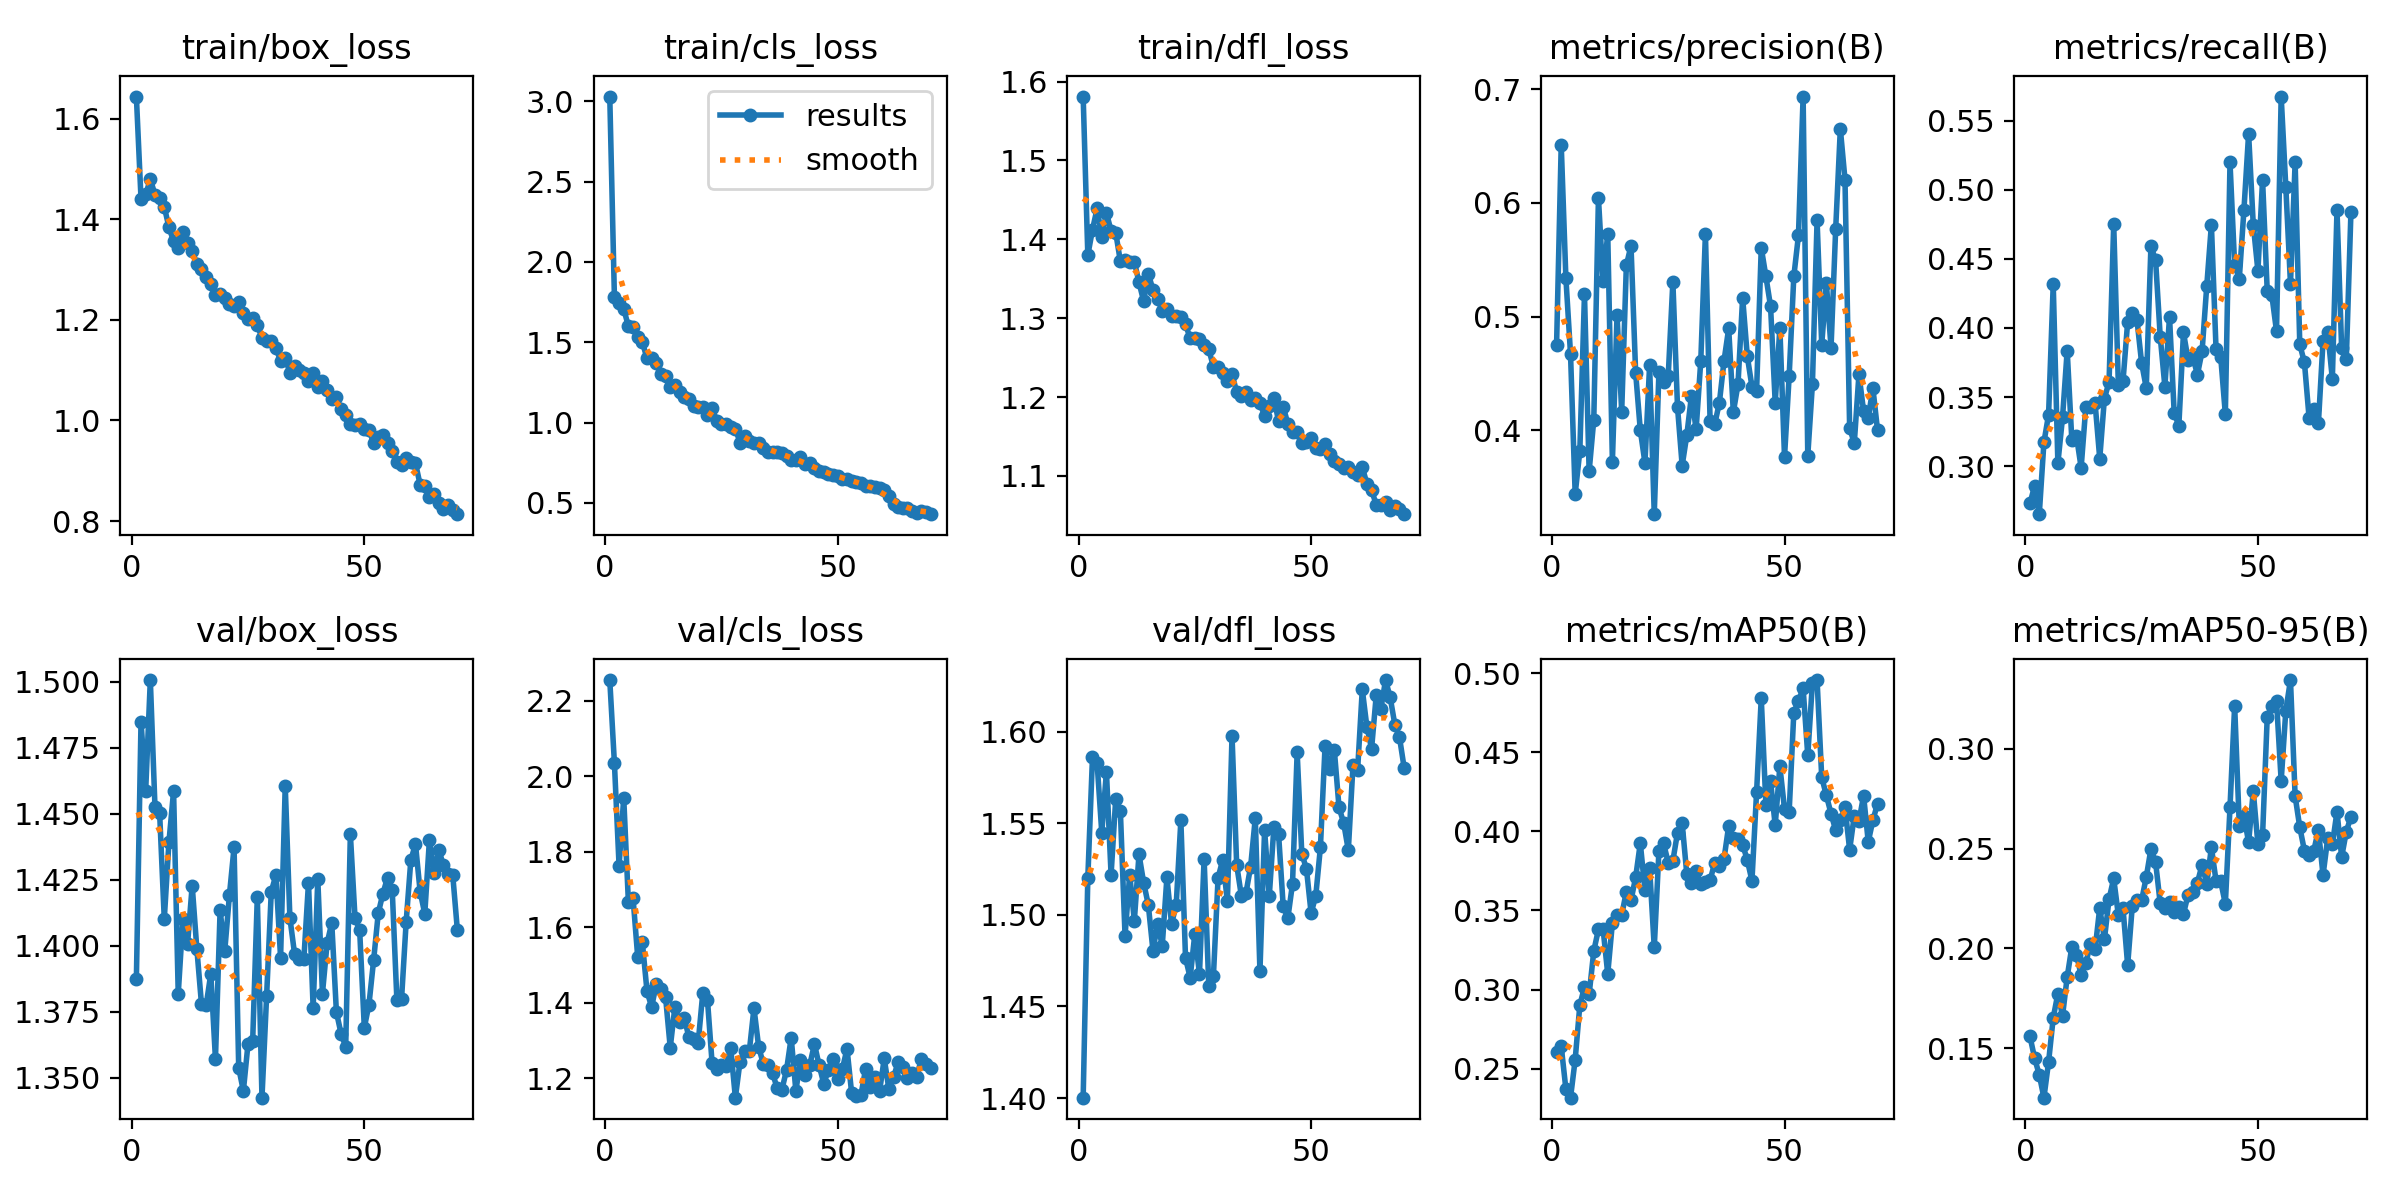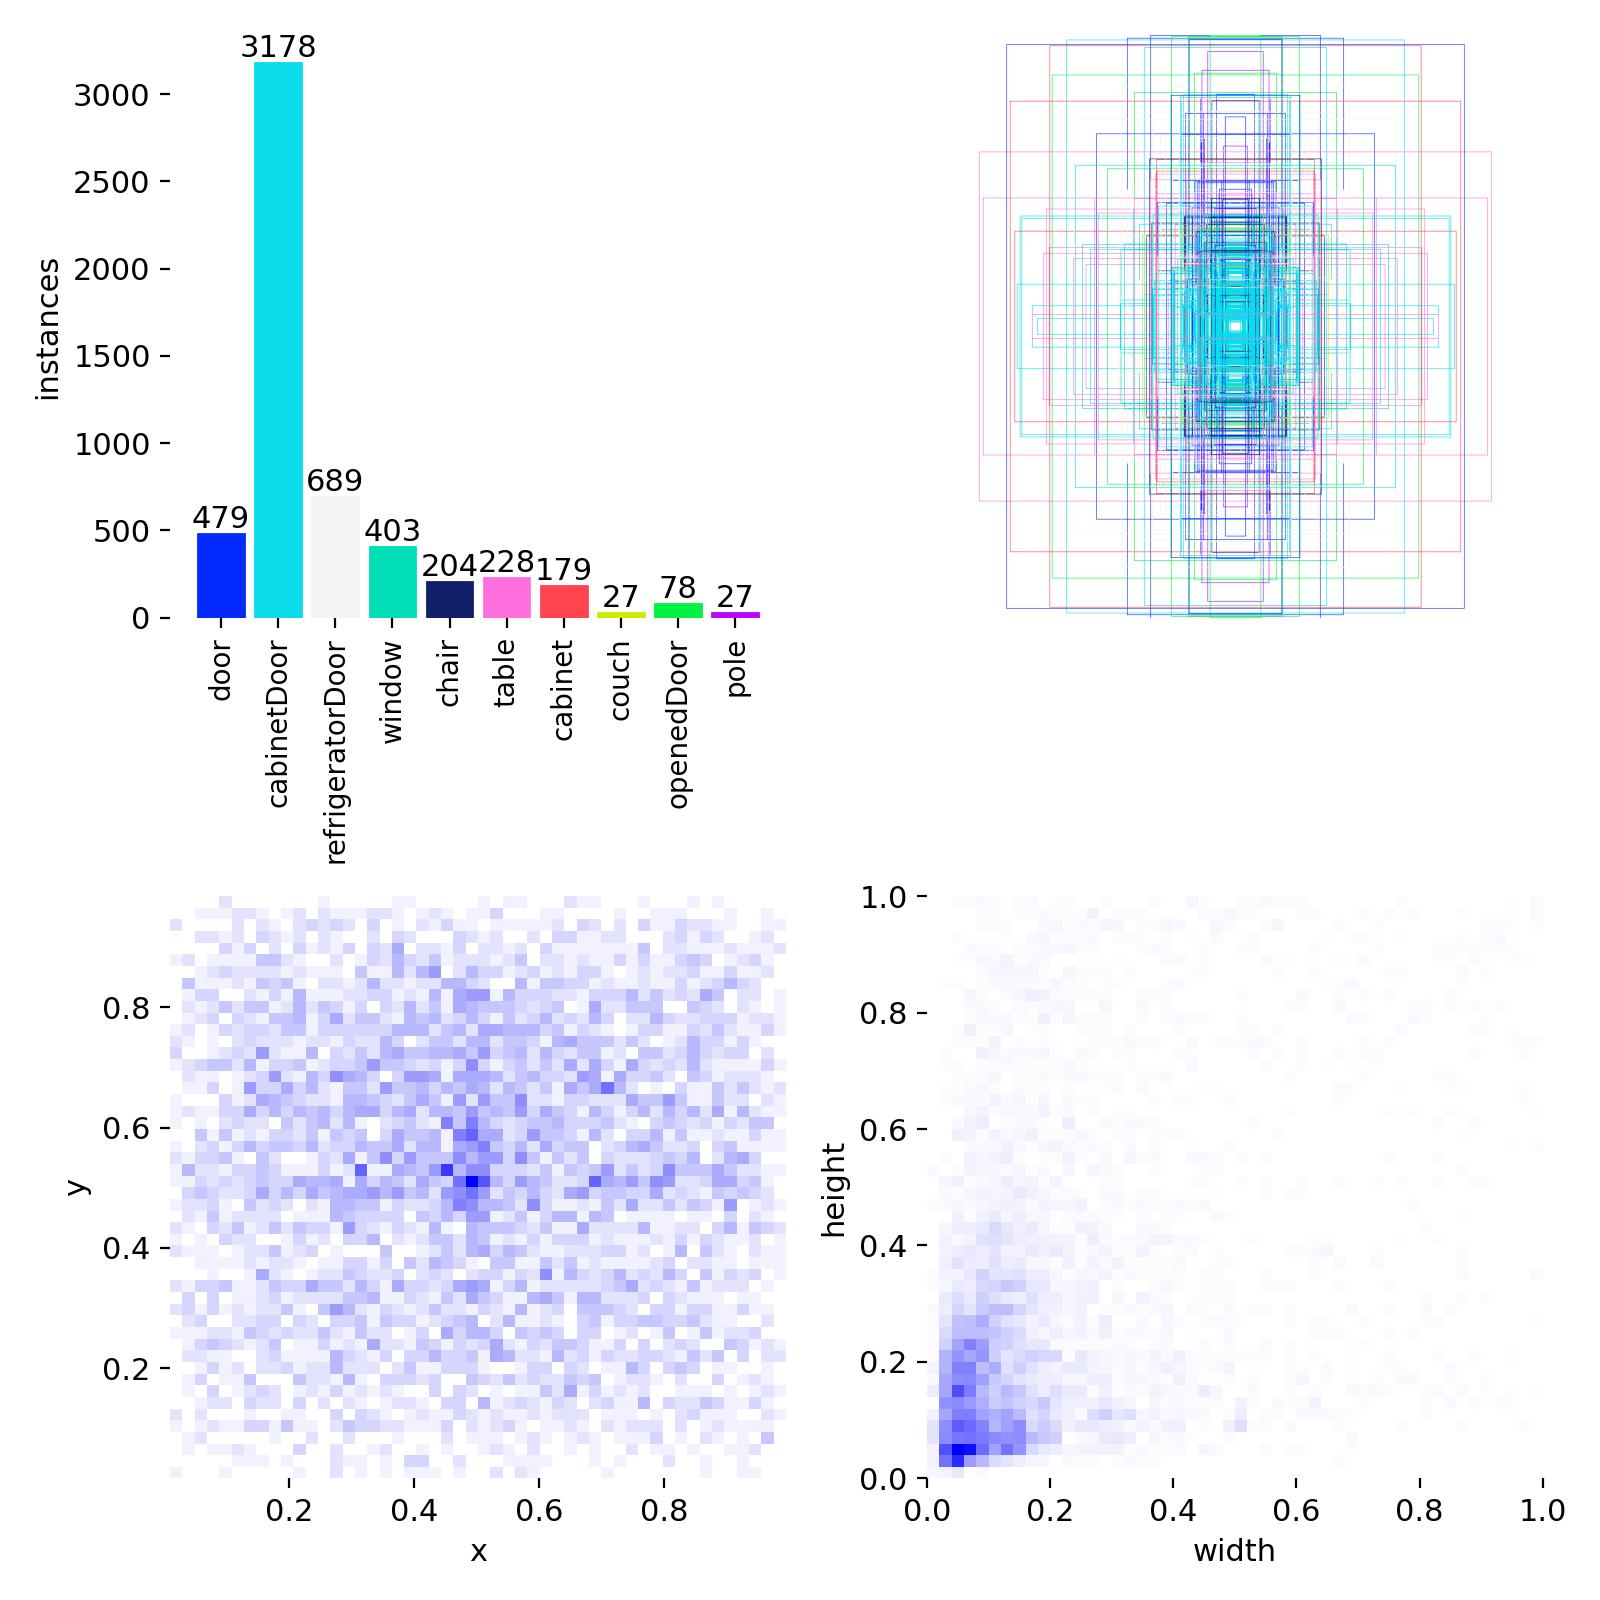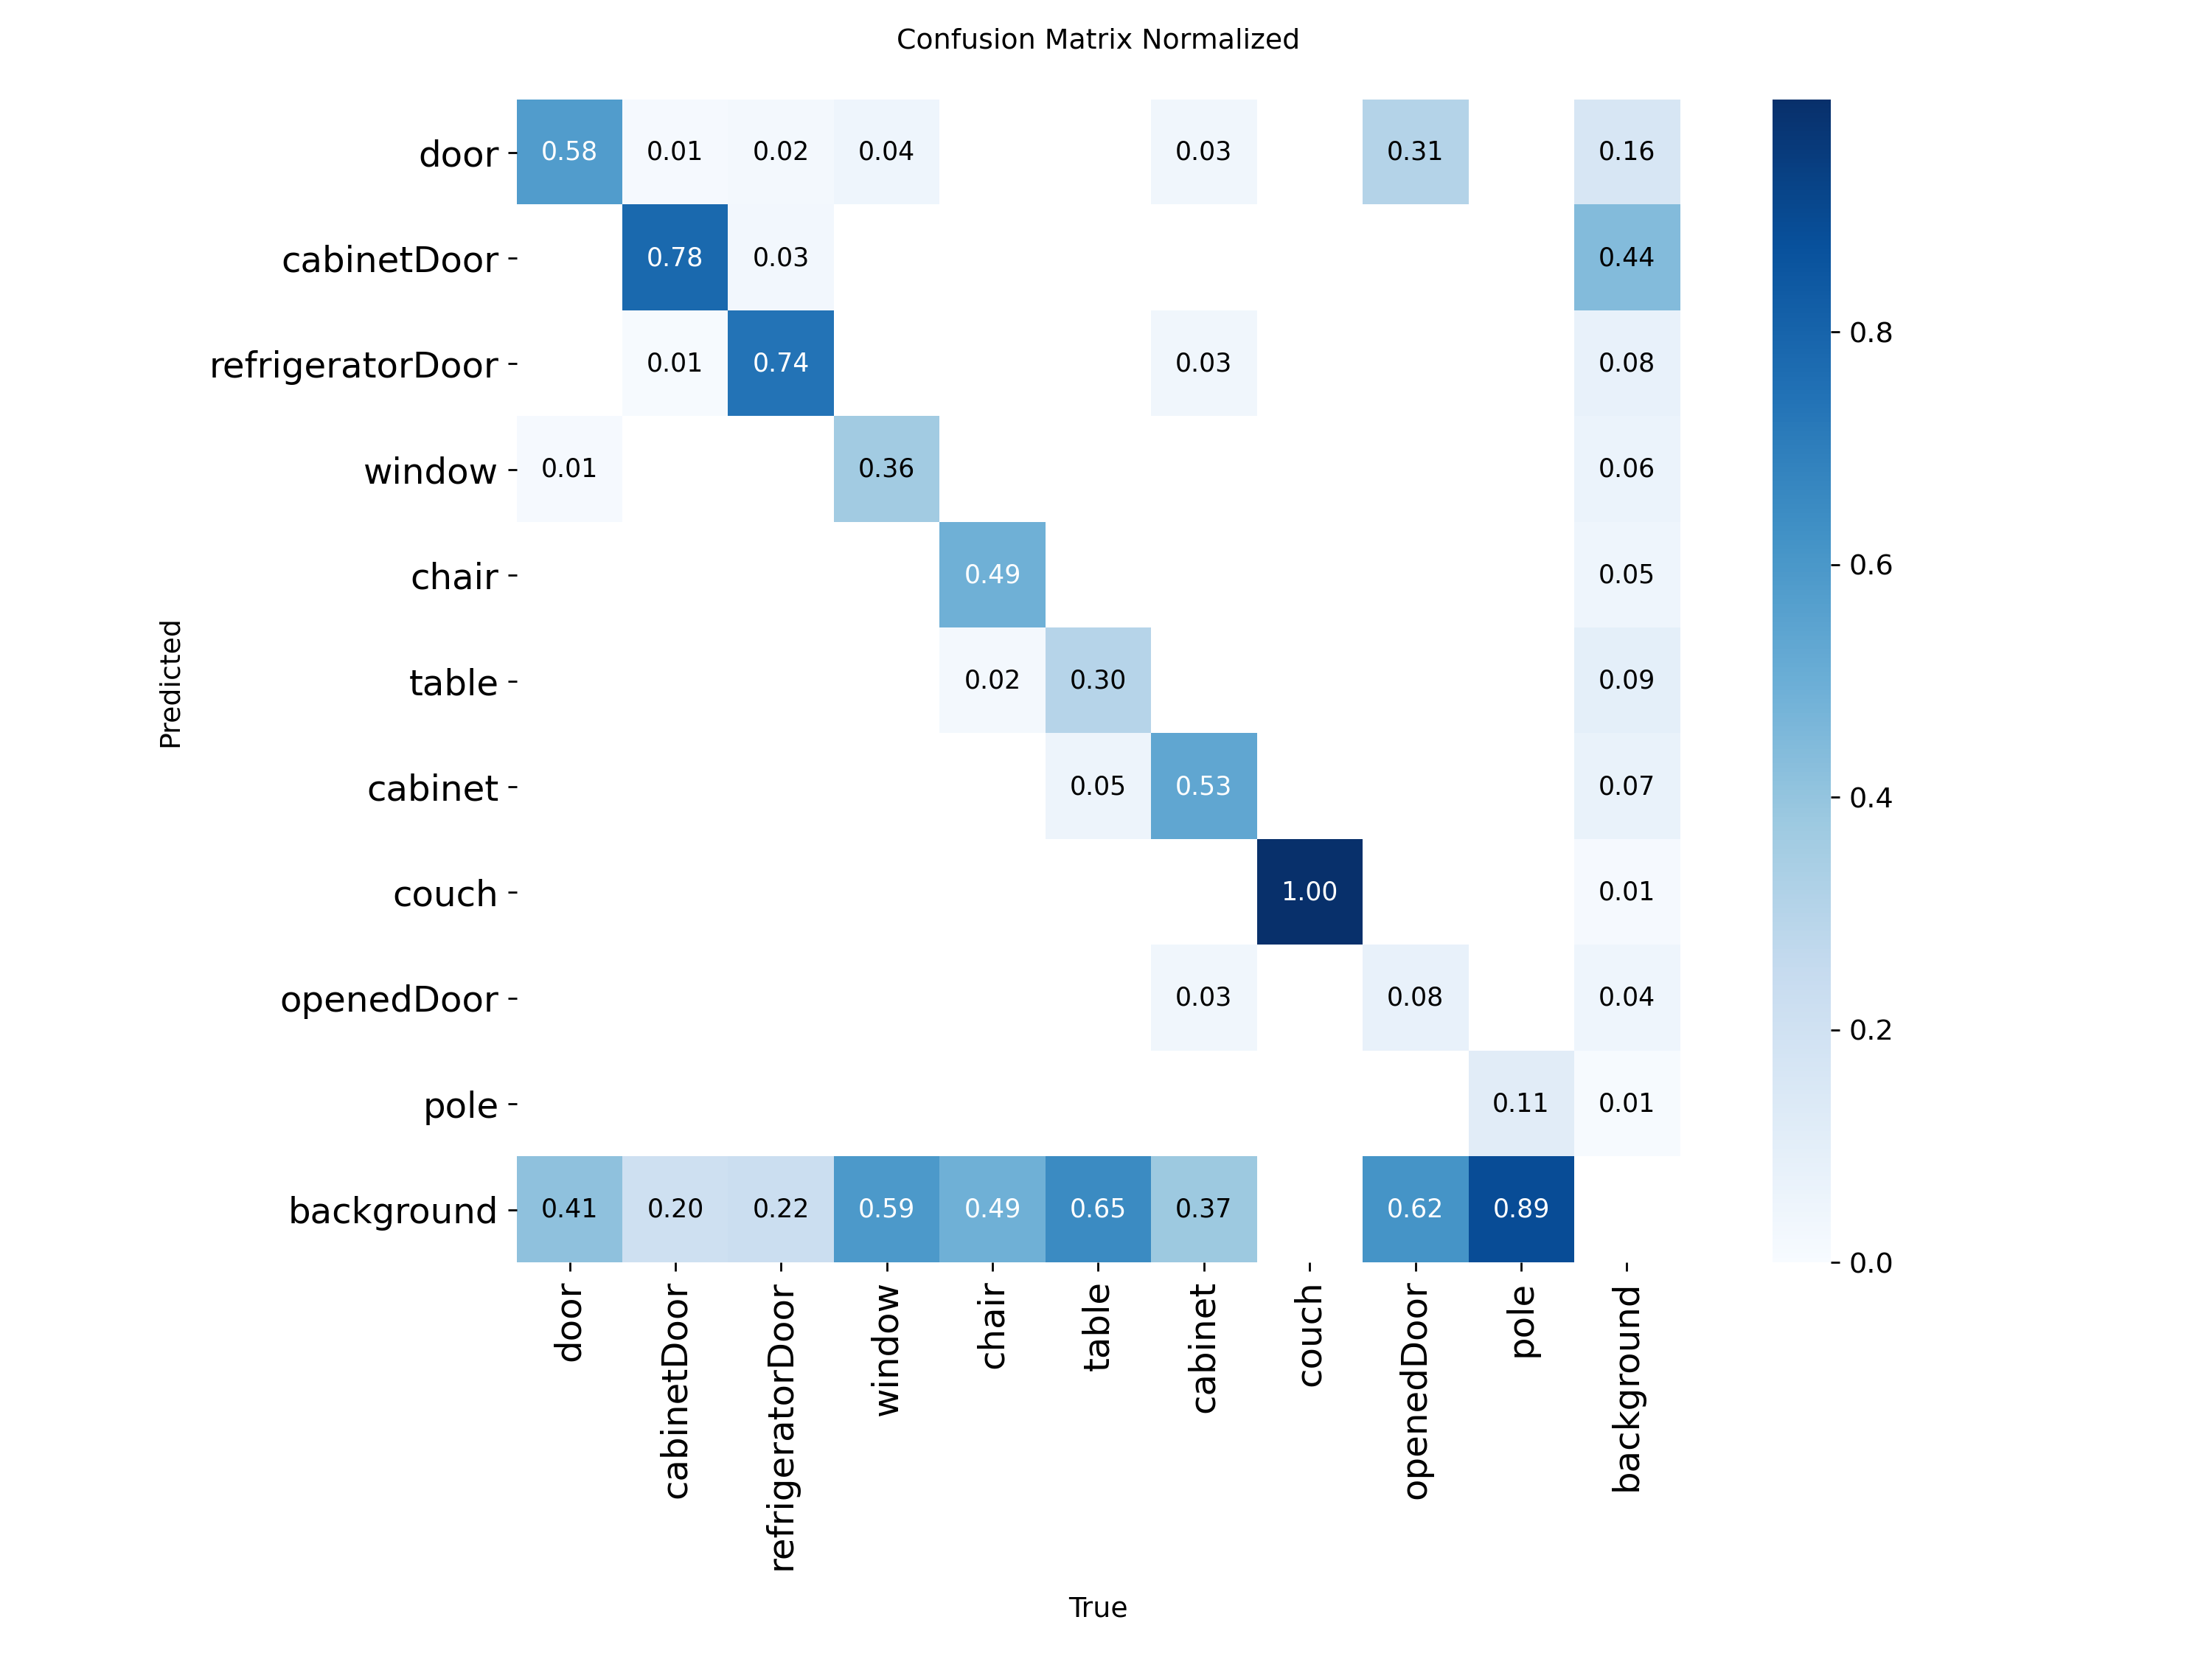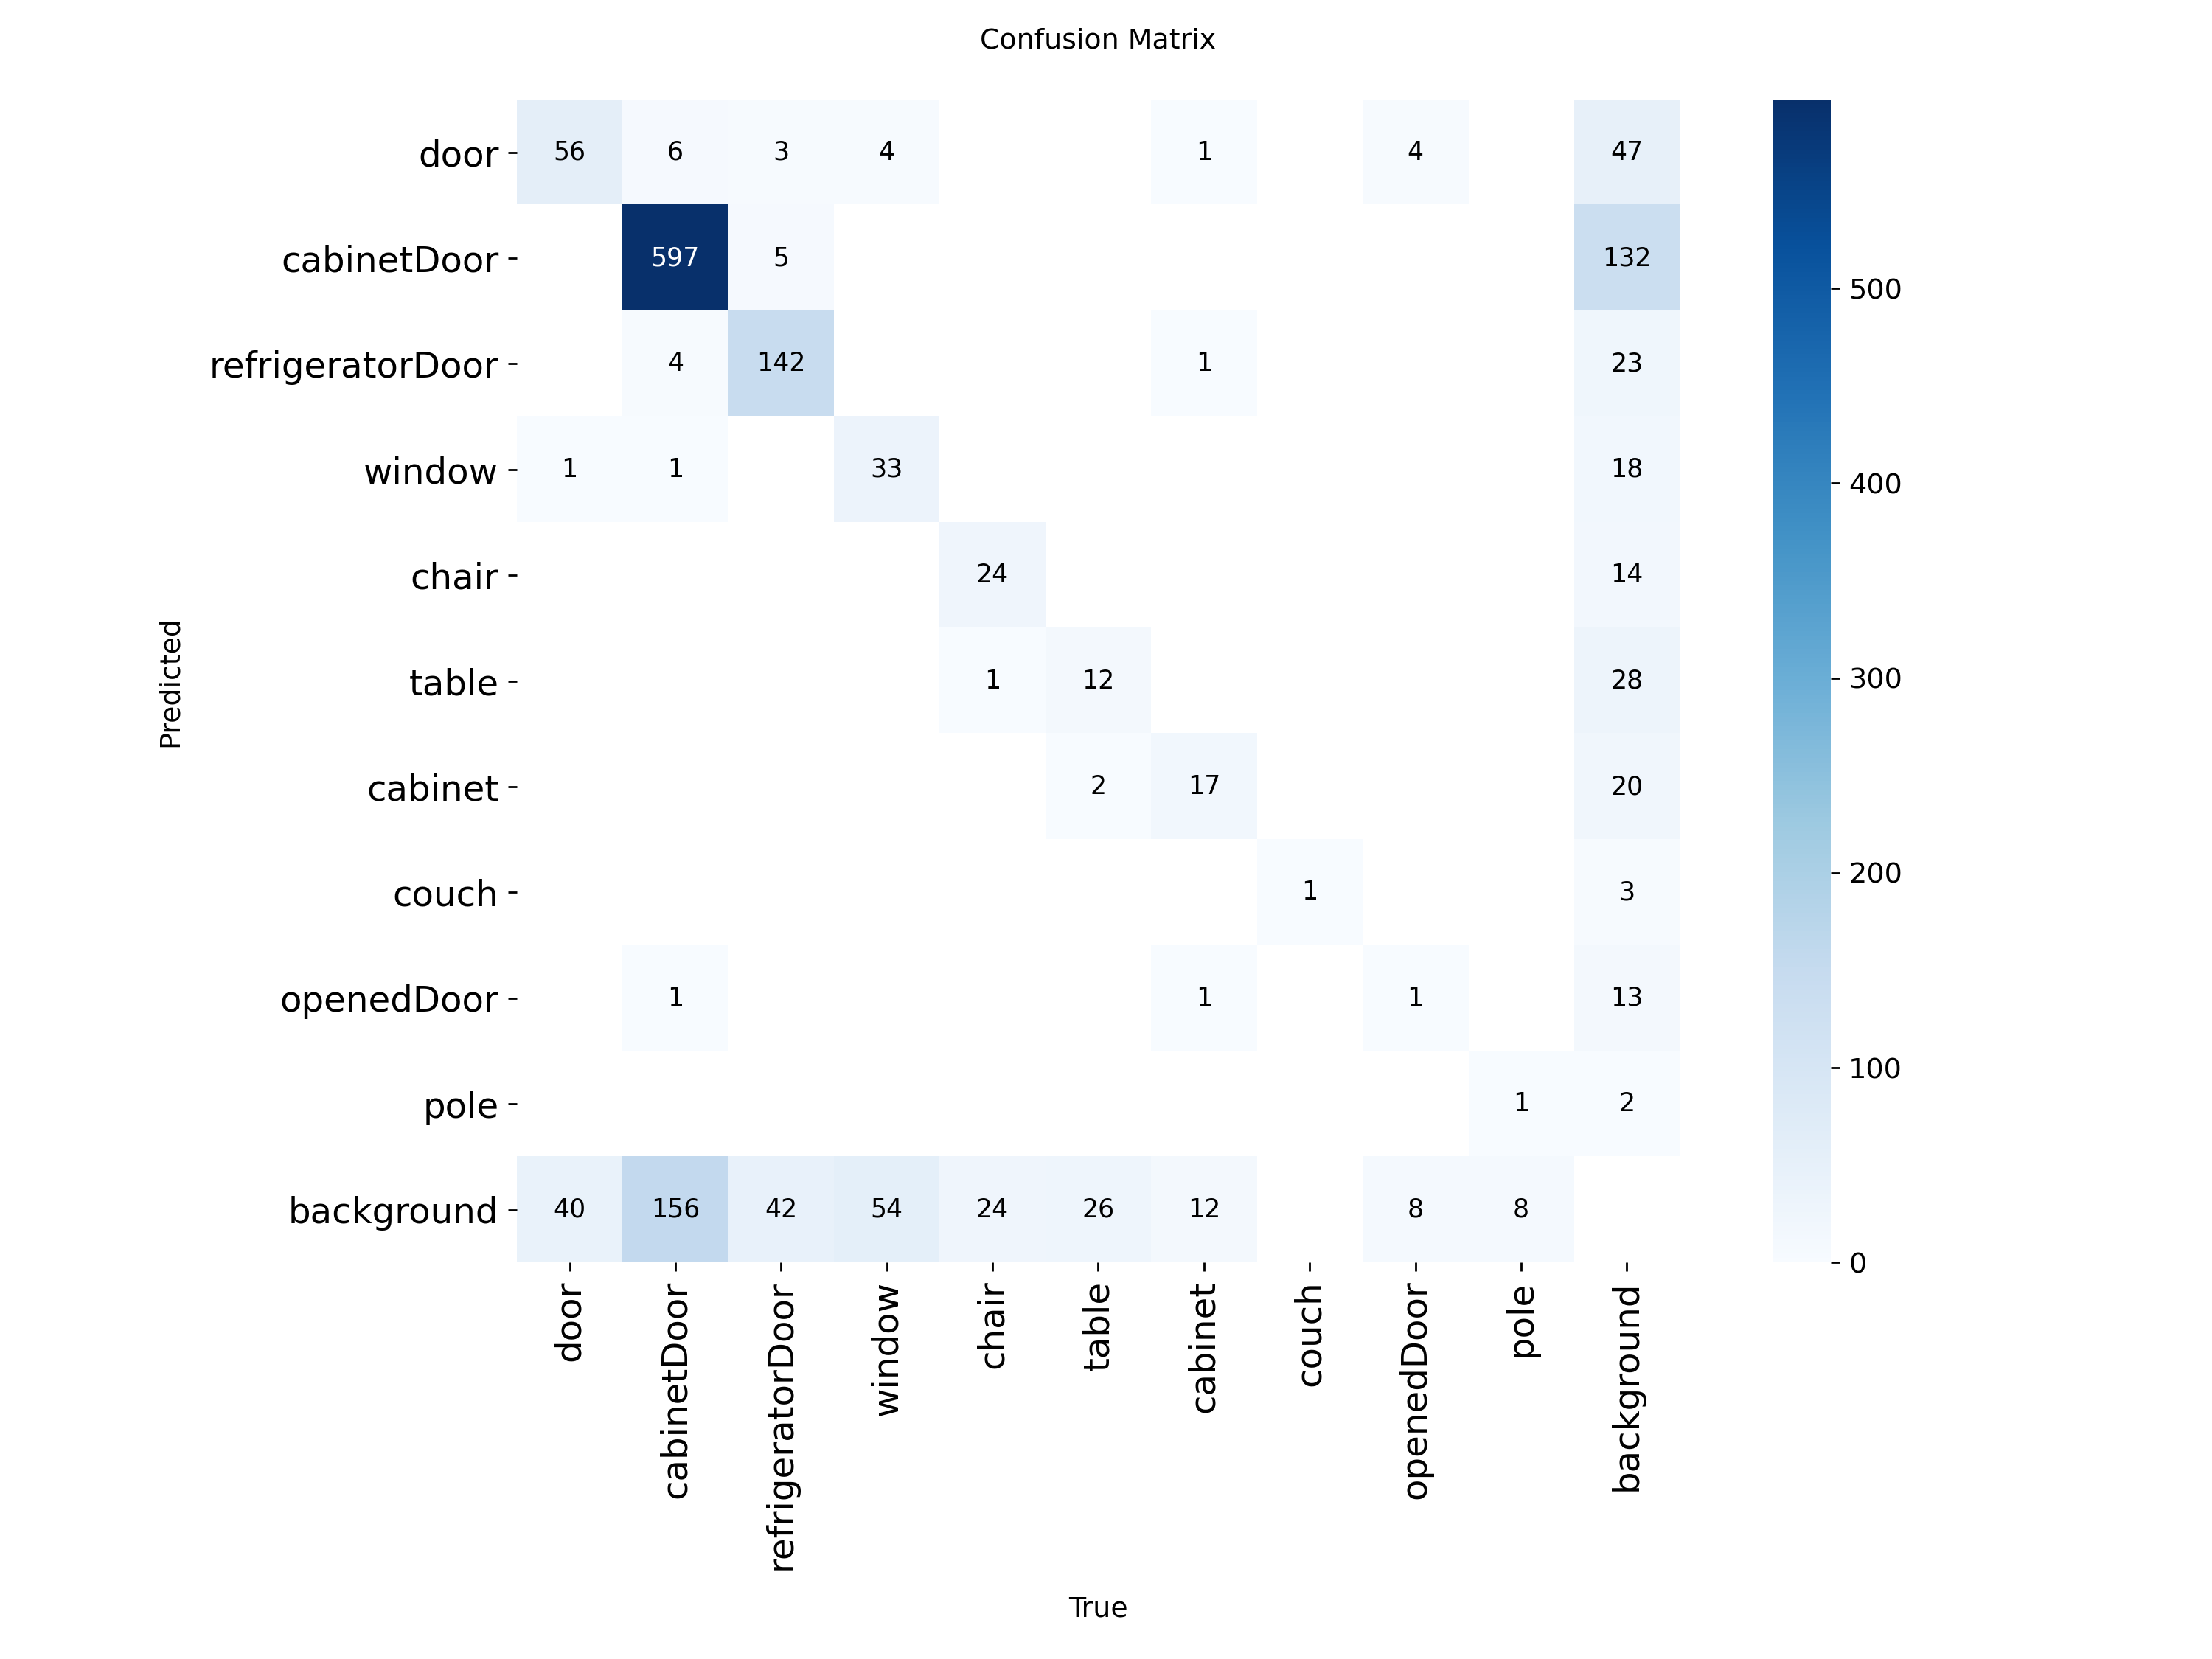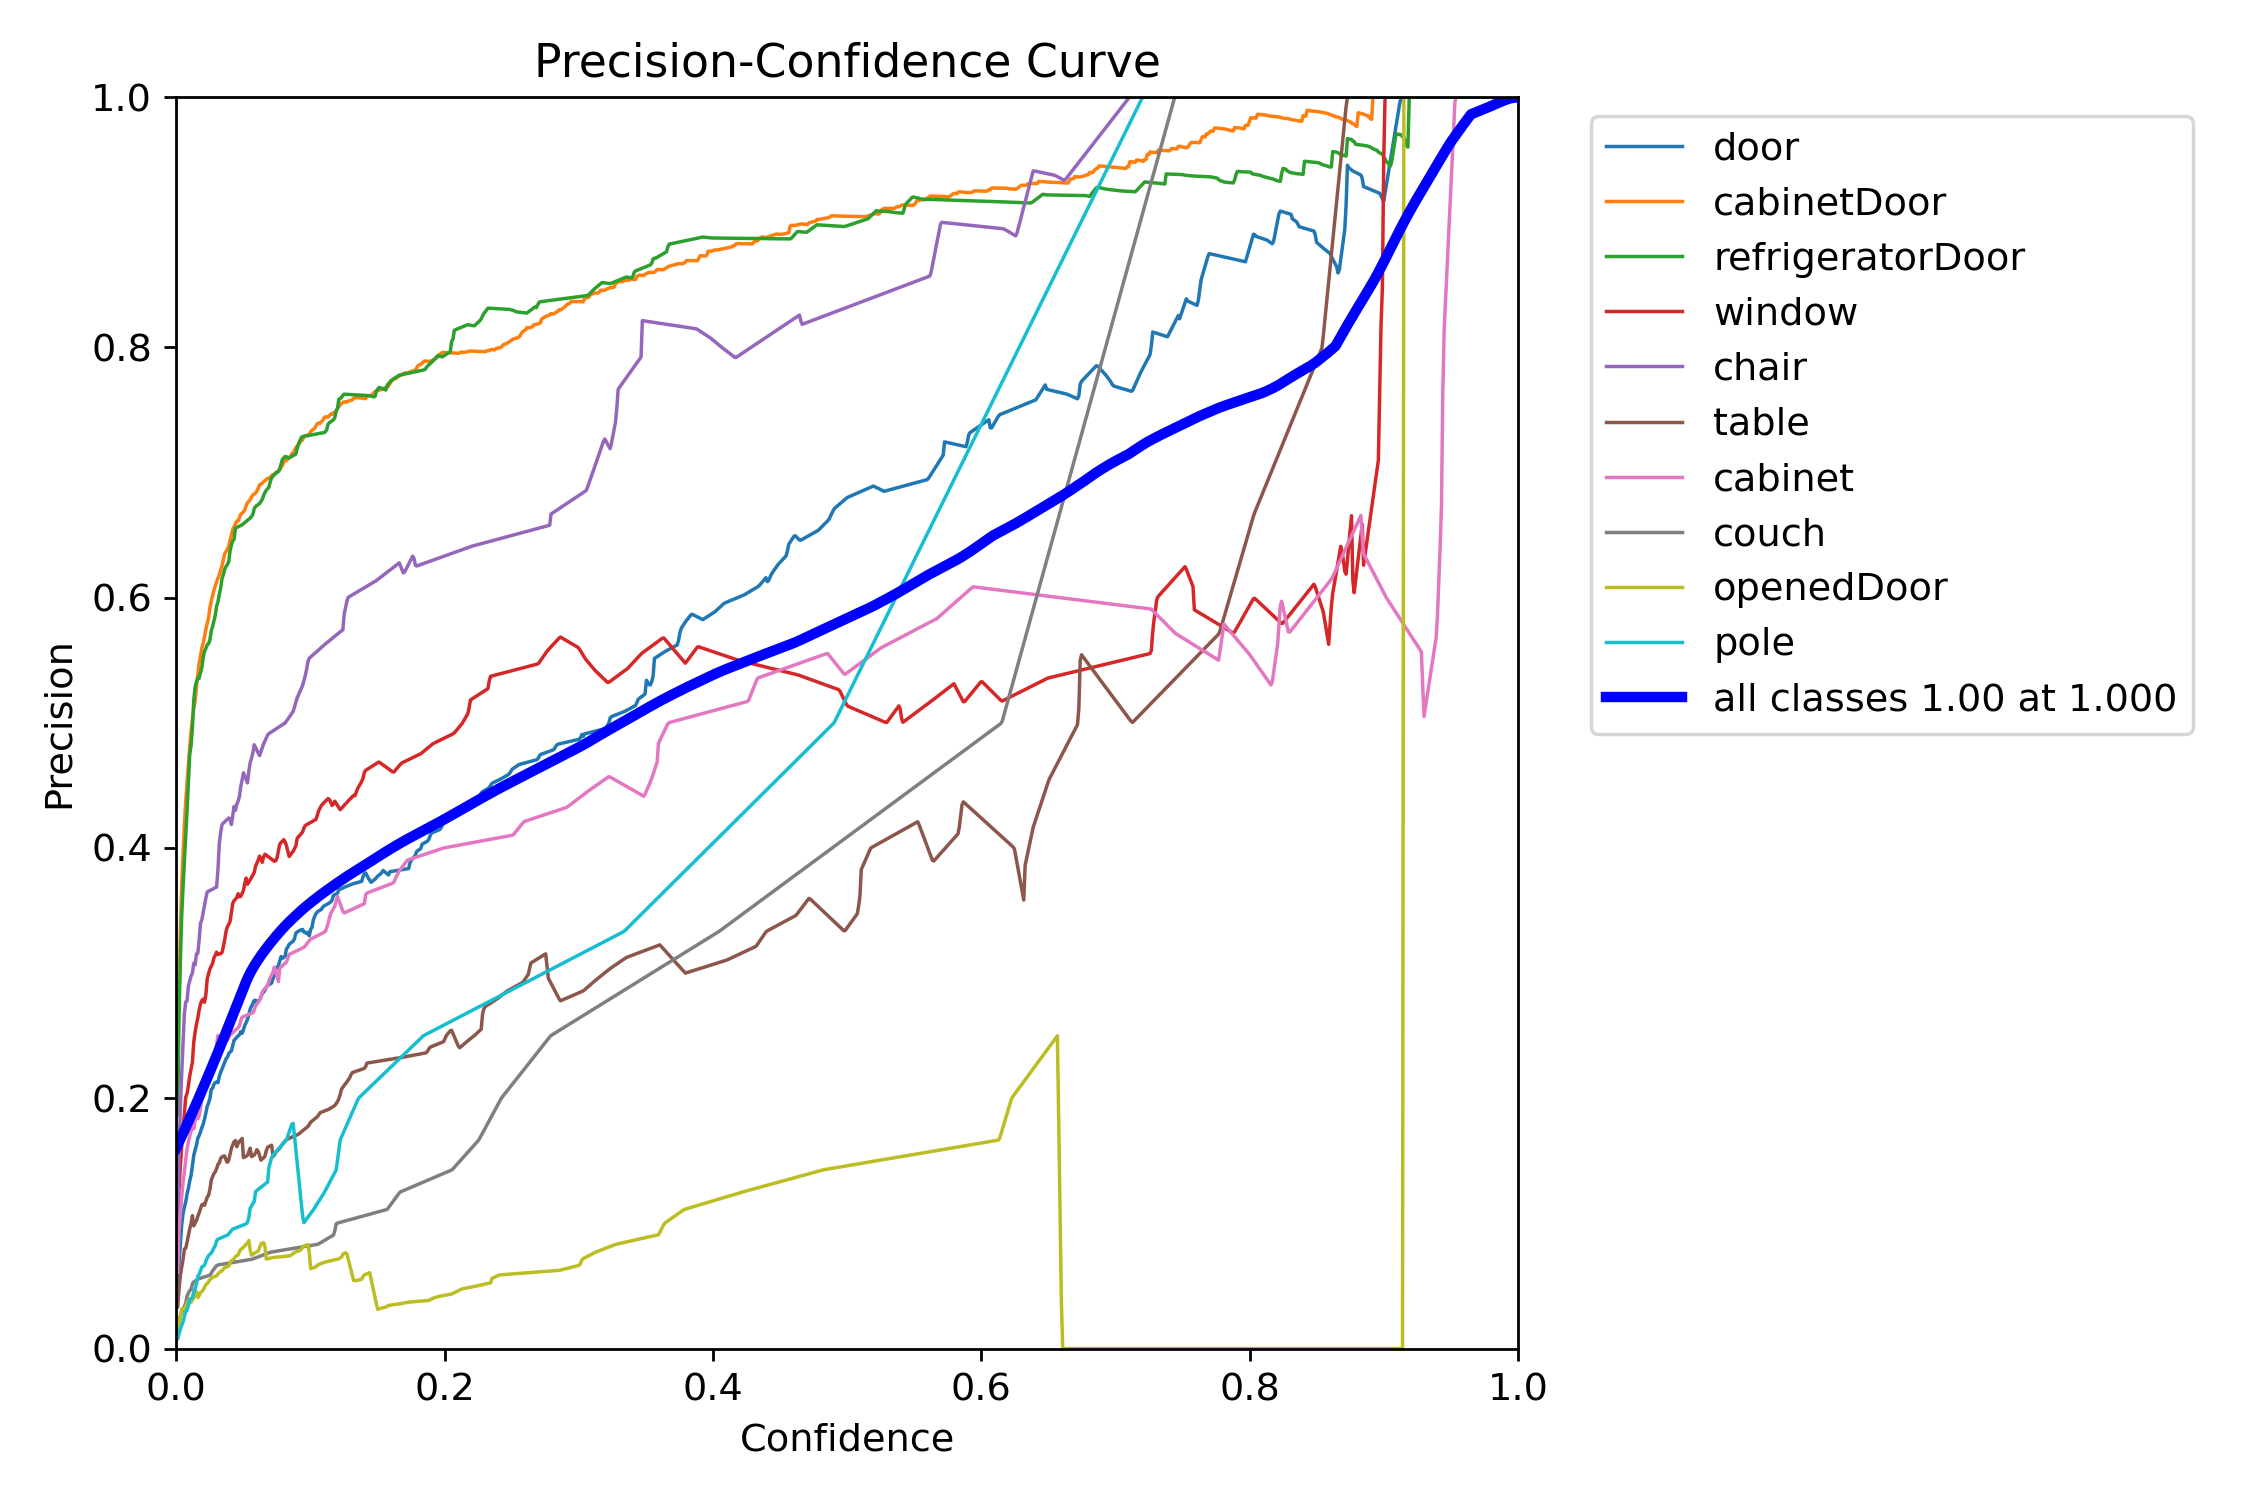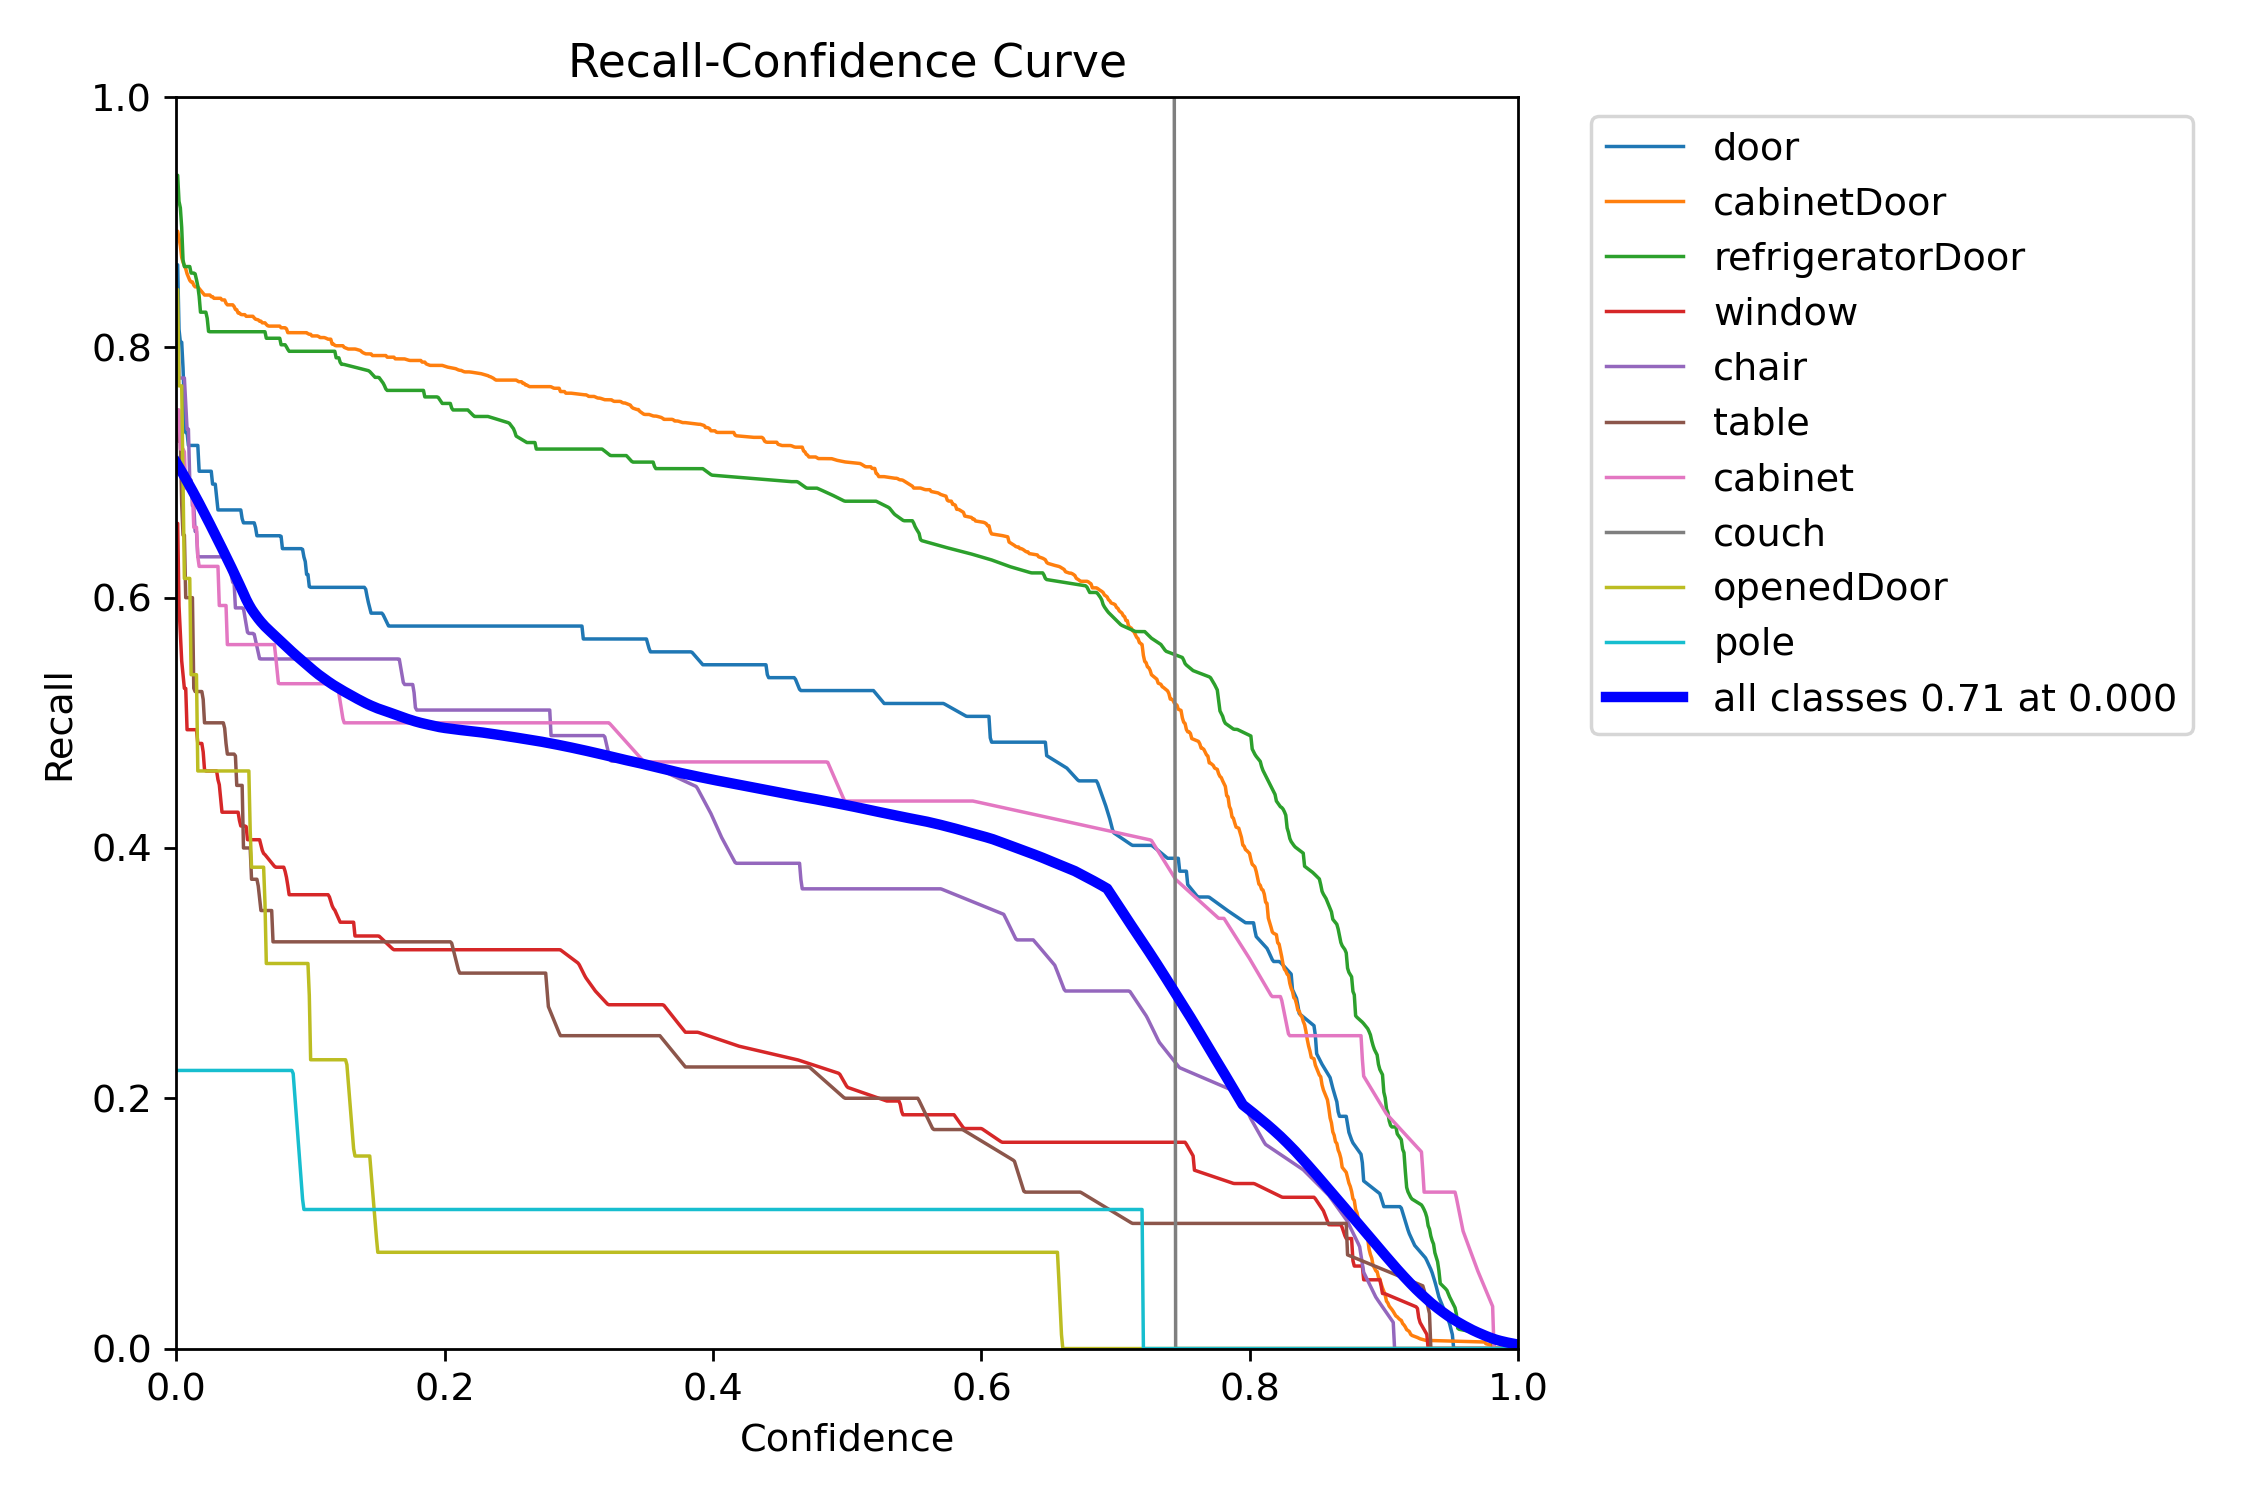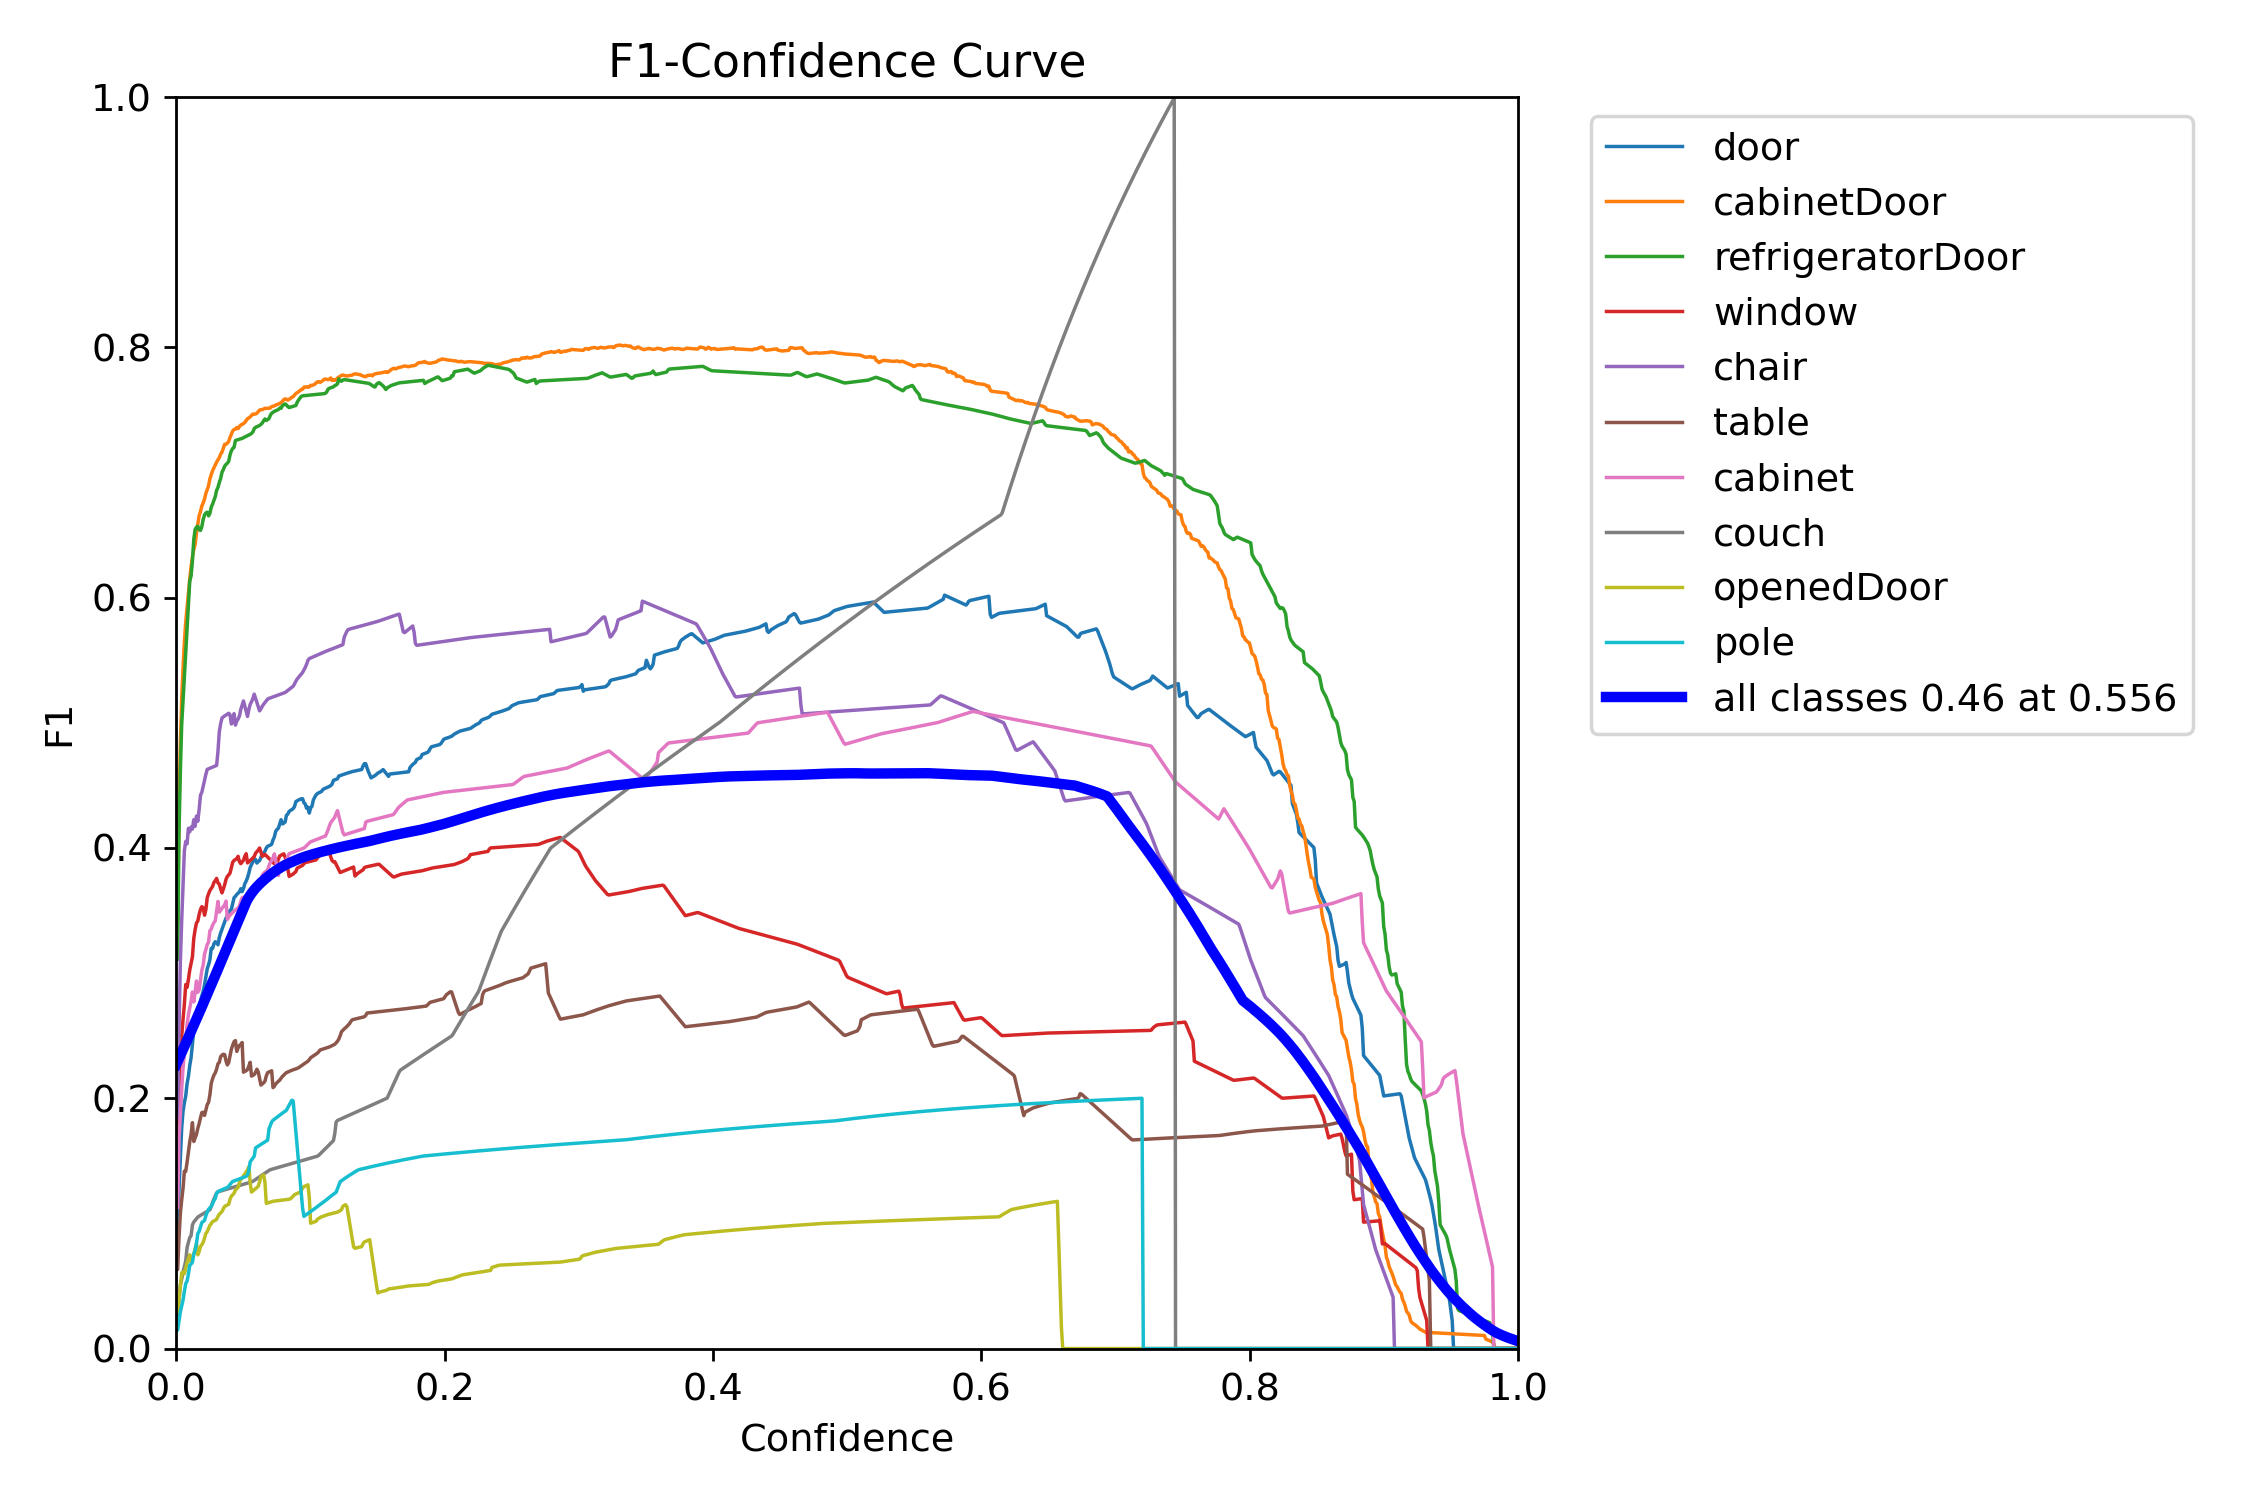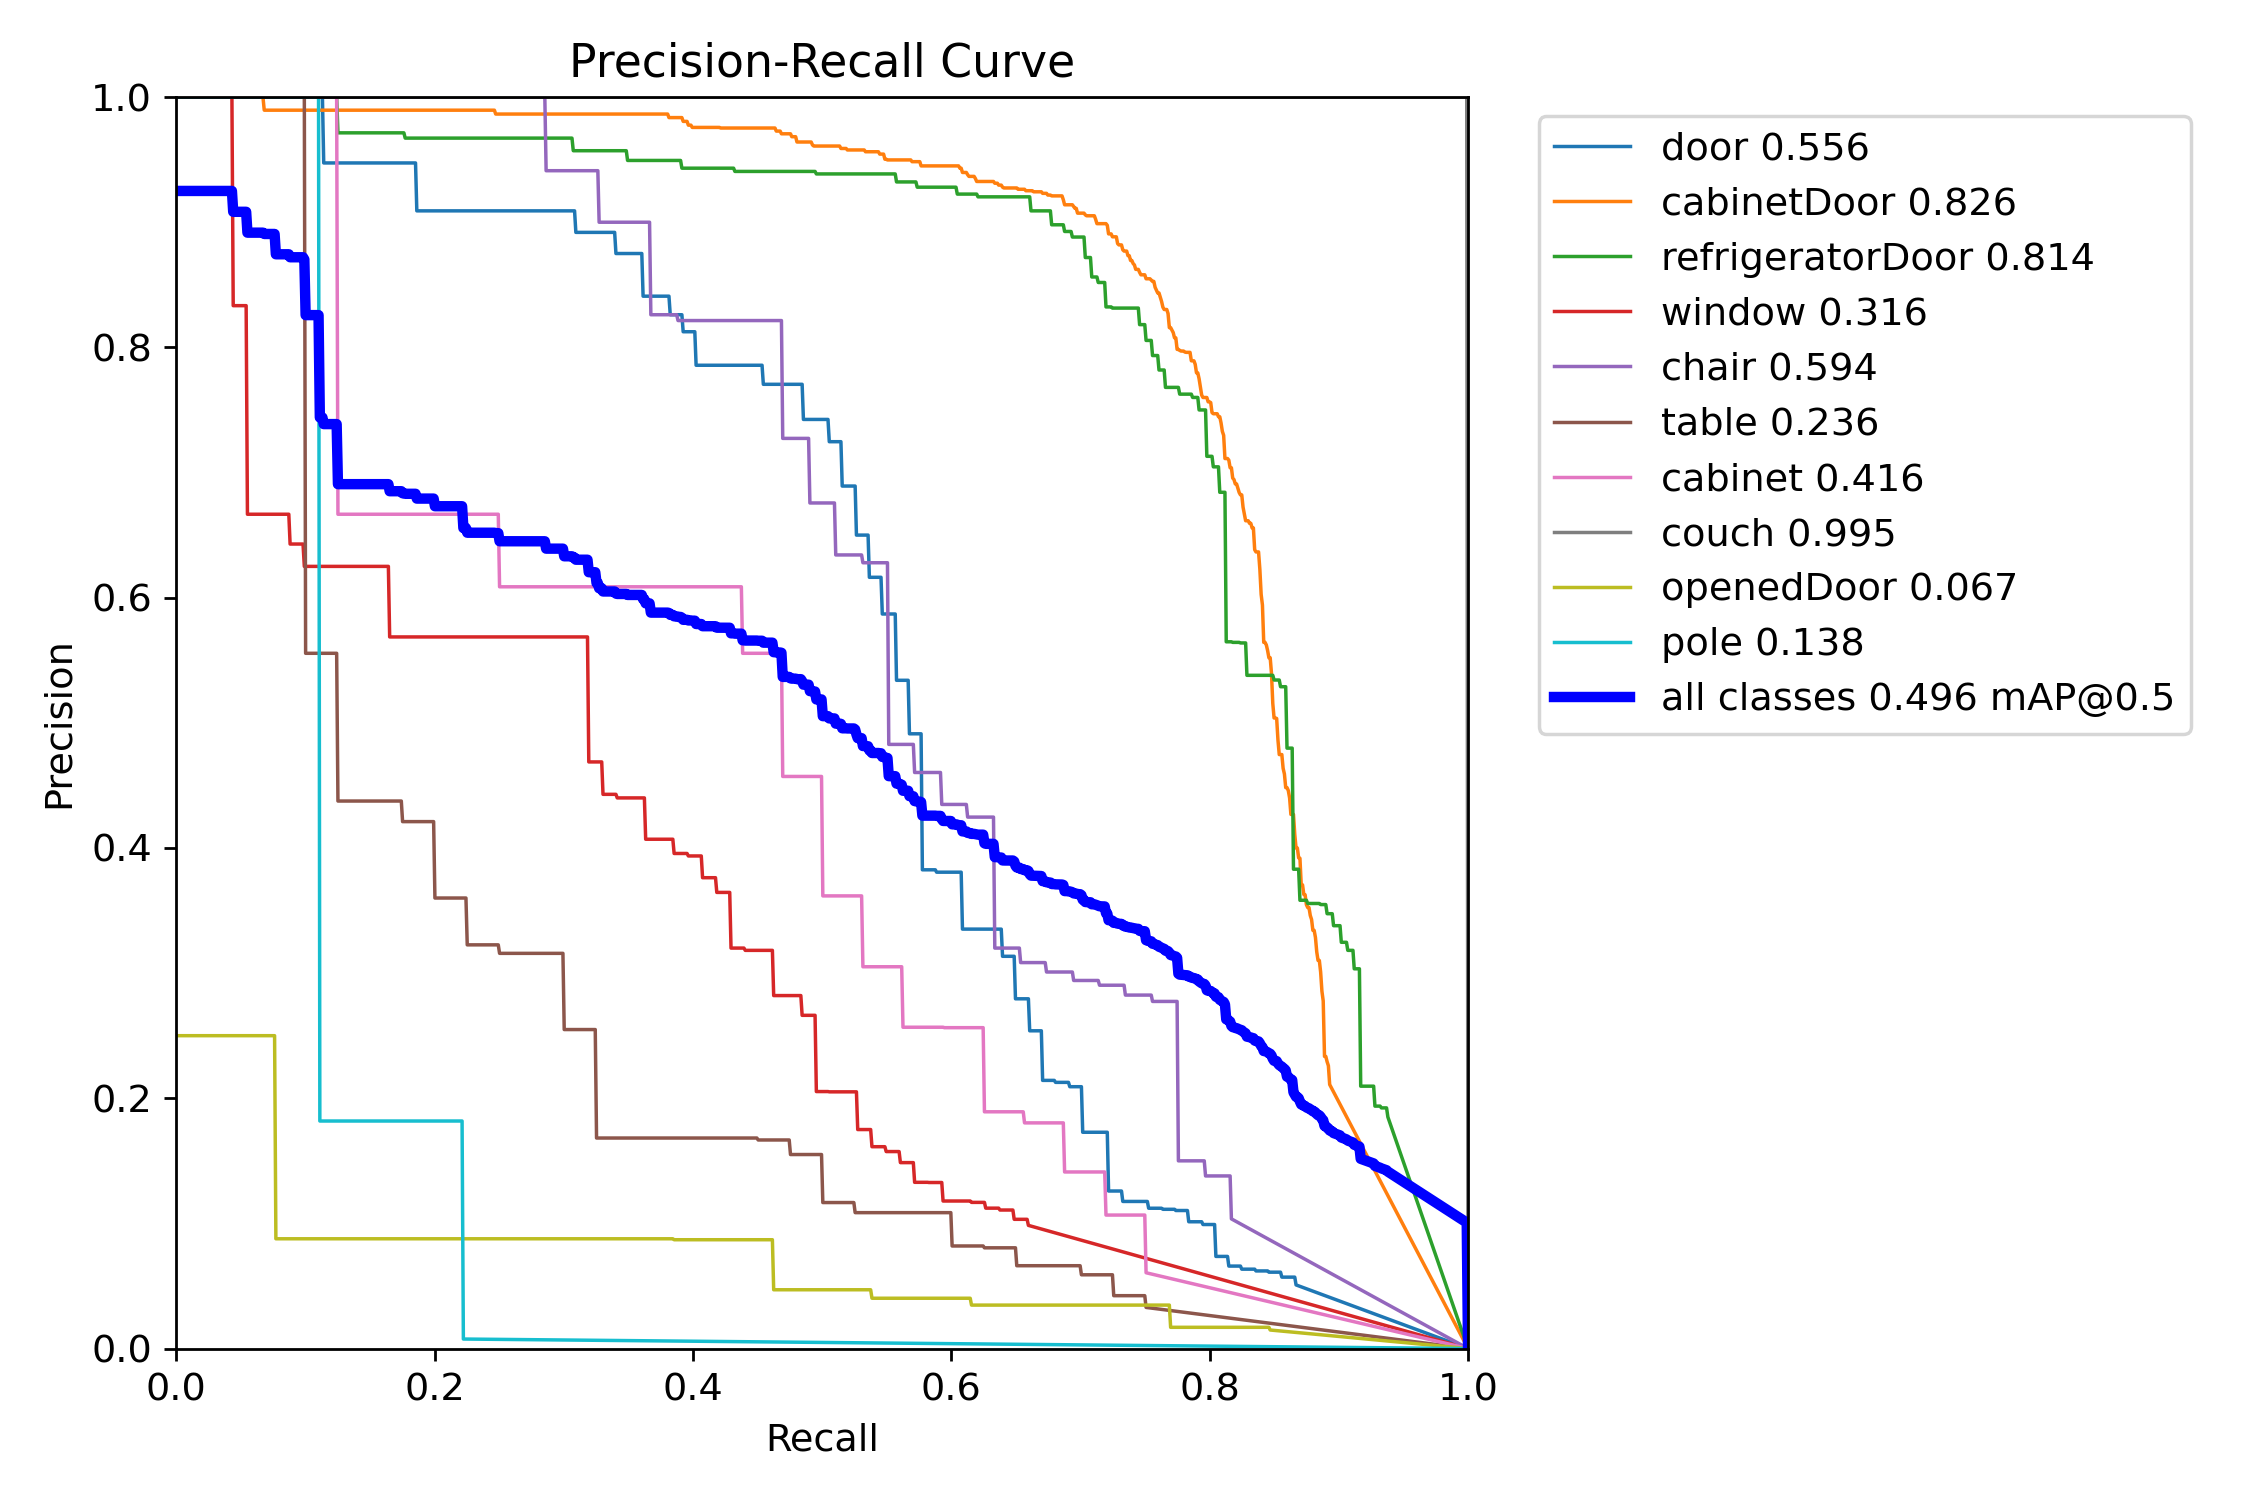

# ***Приклад розпізнавання.***

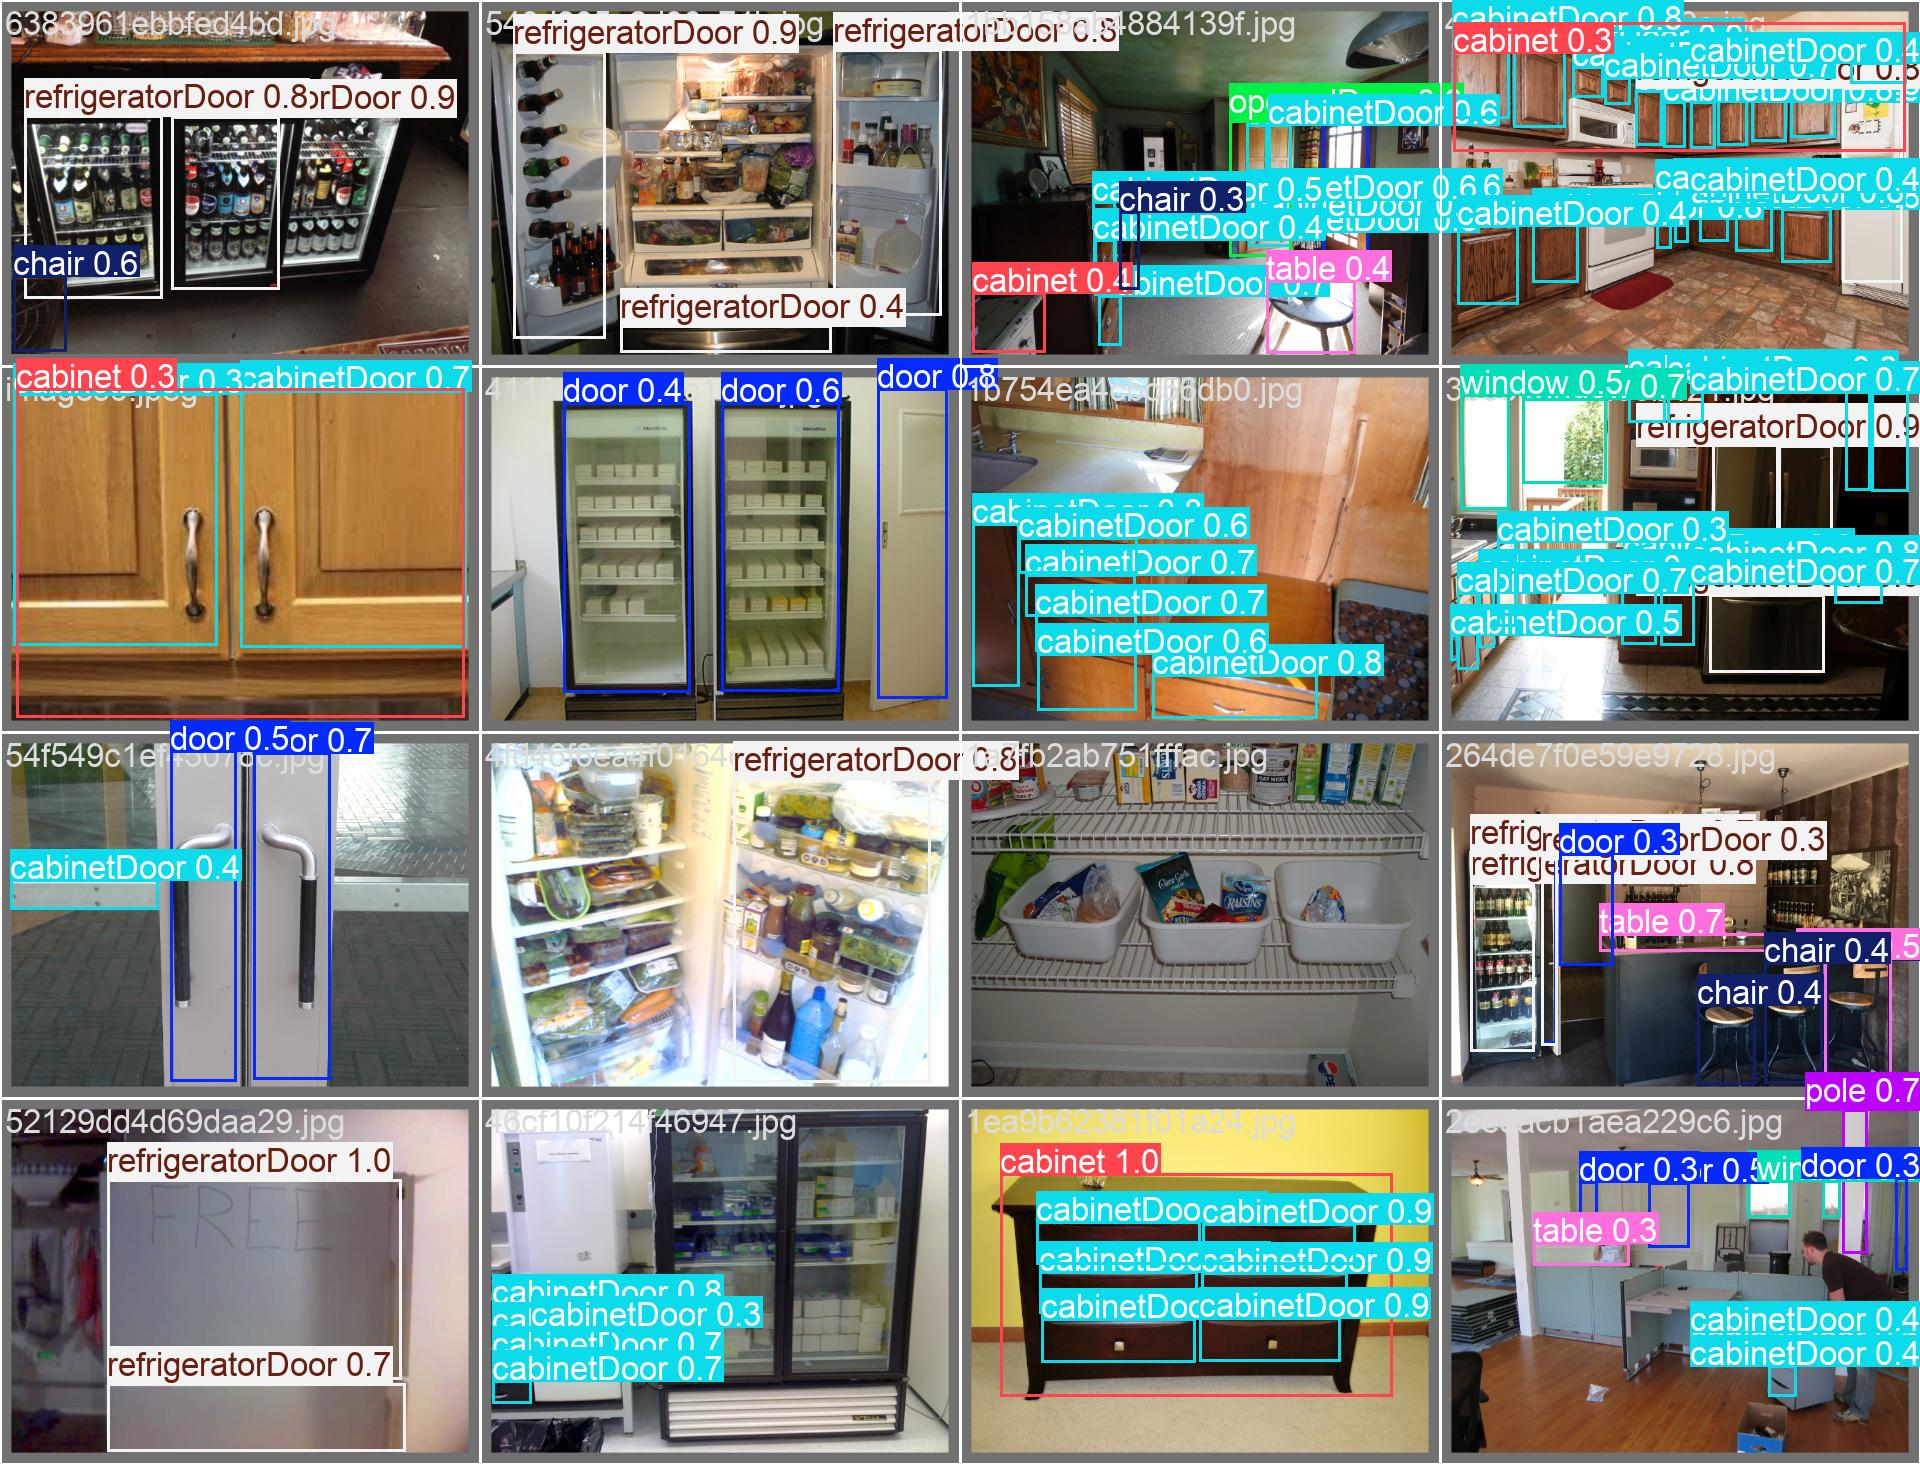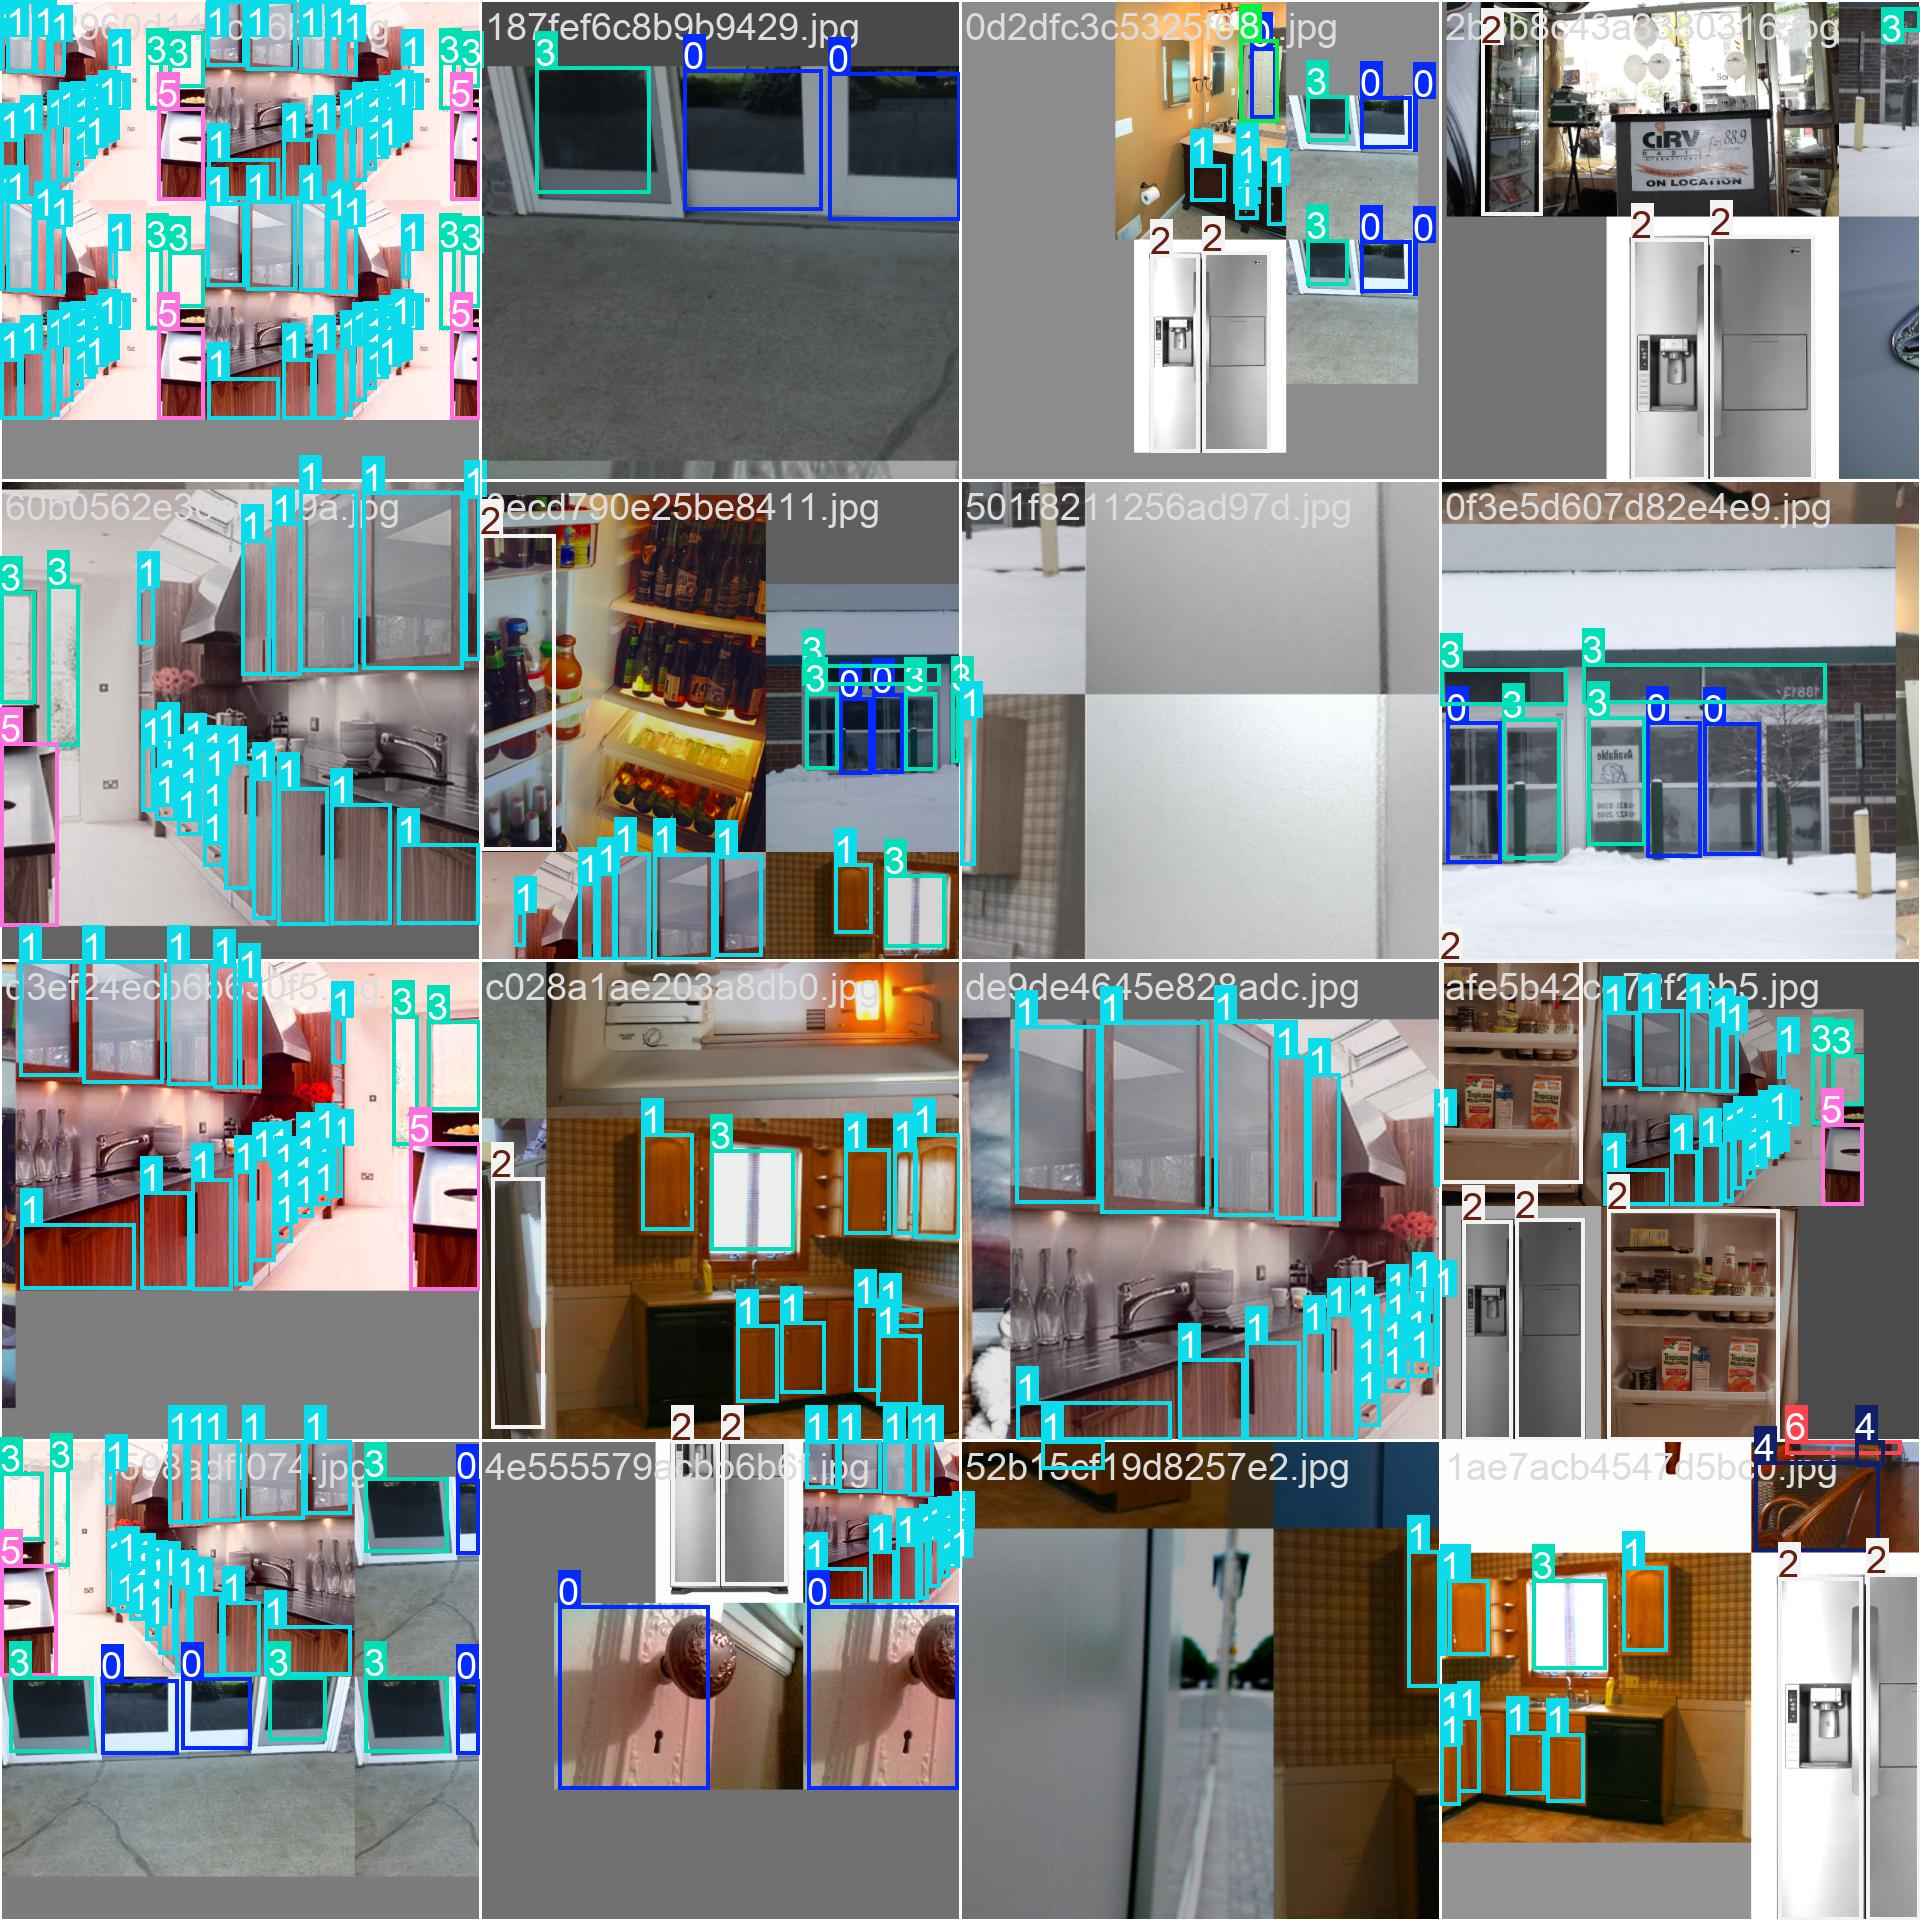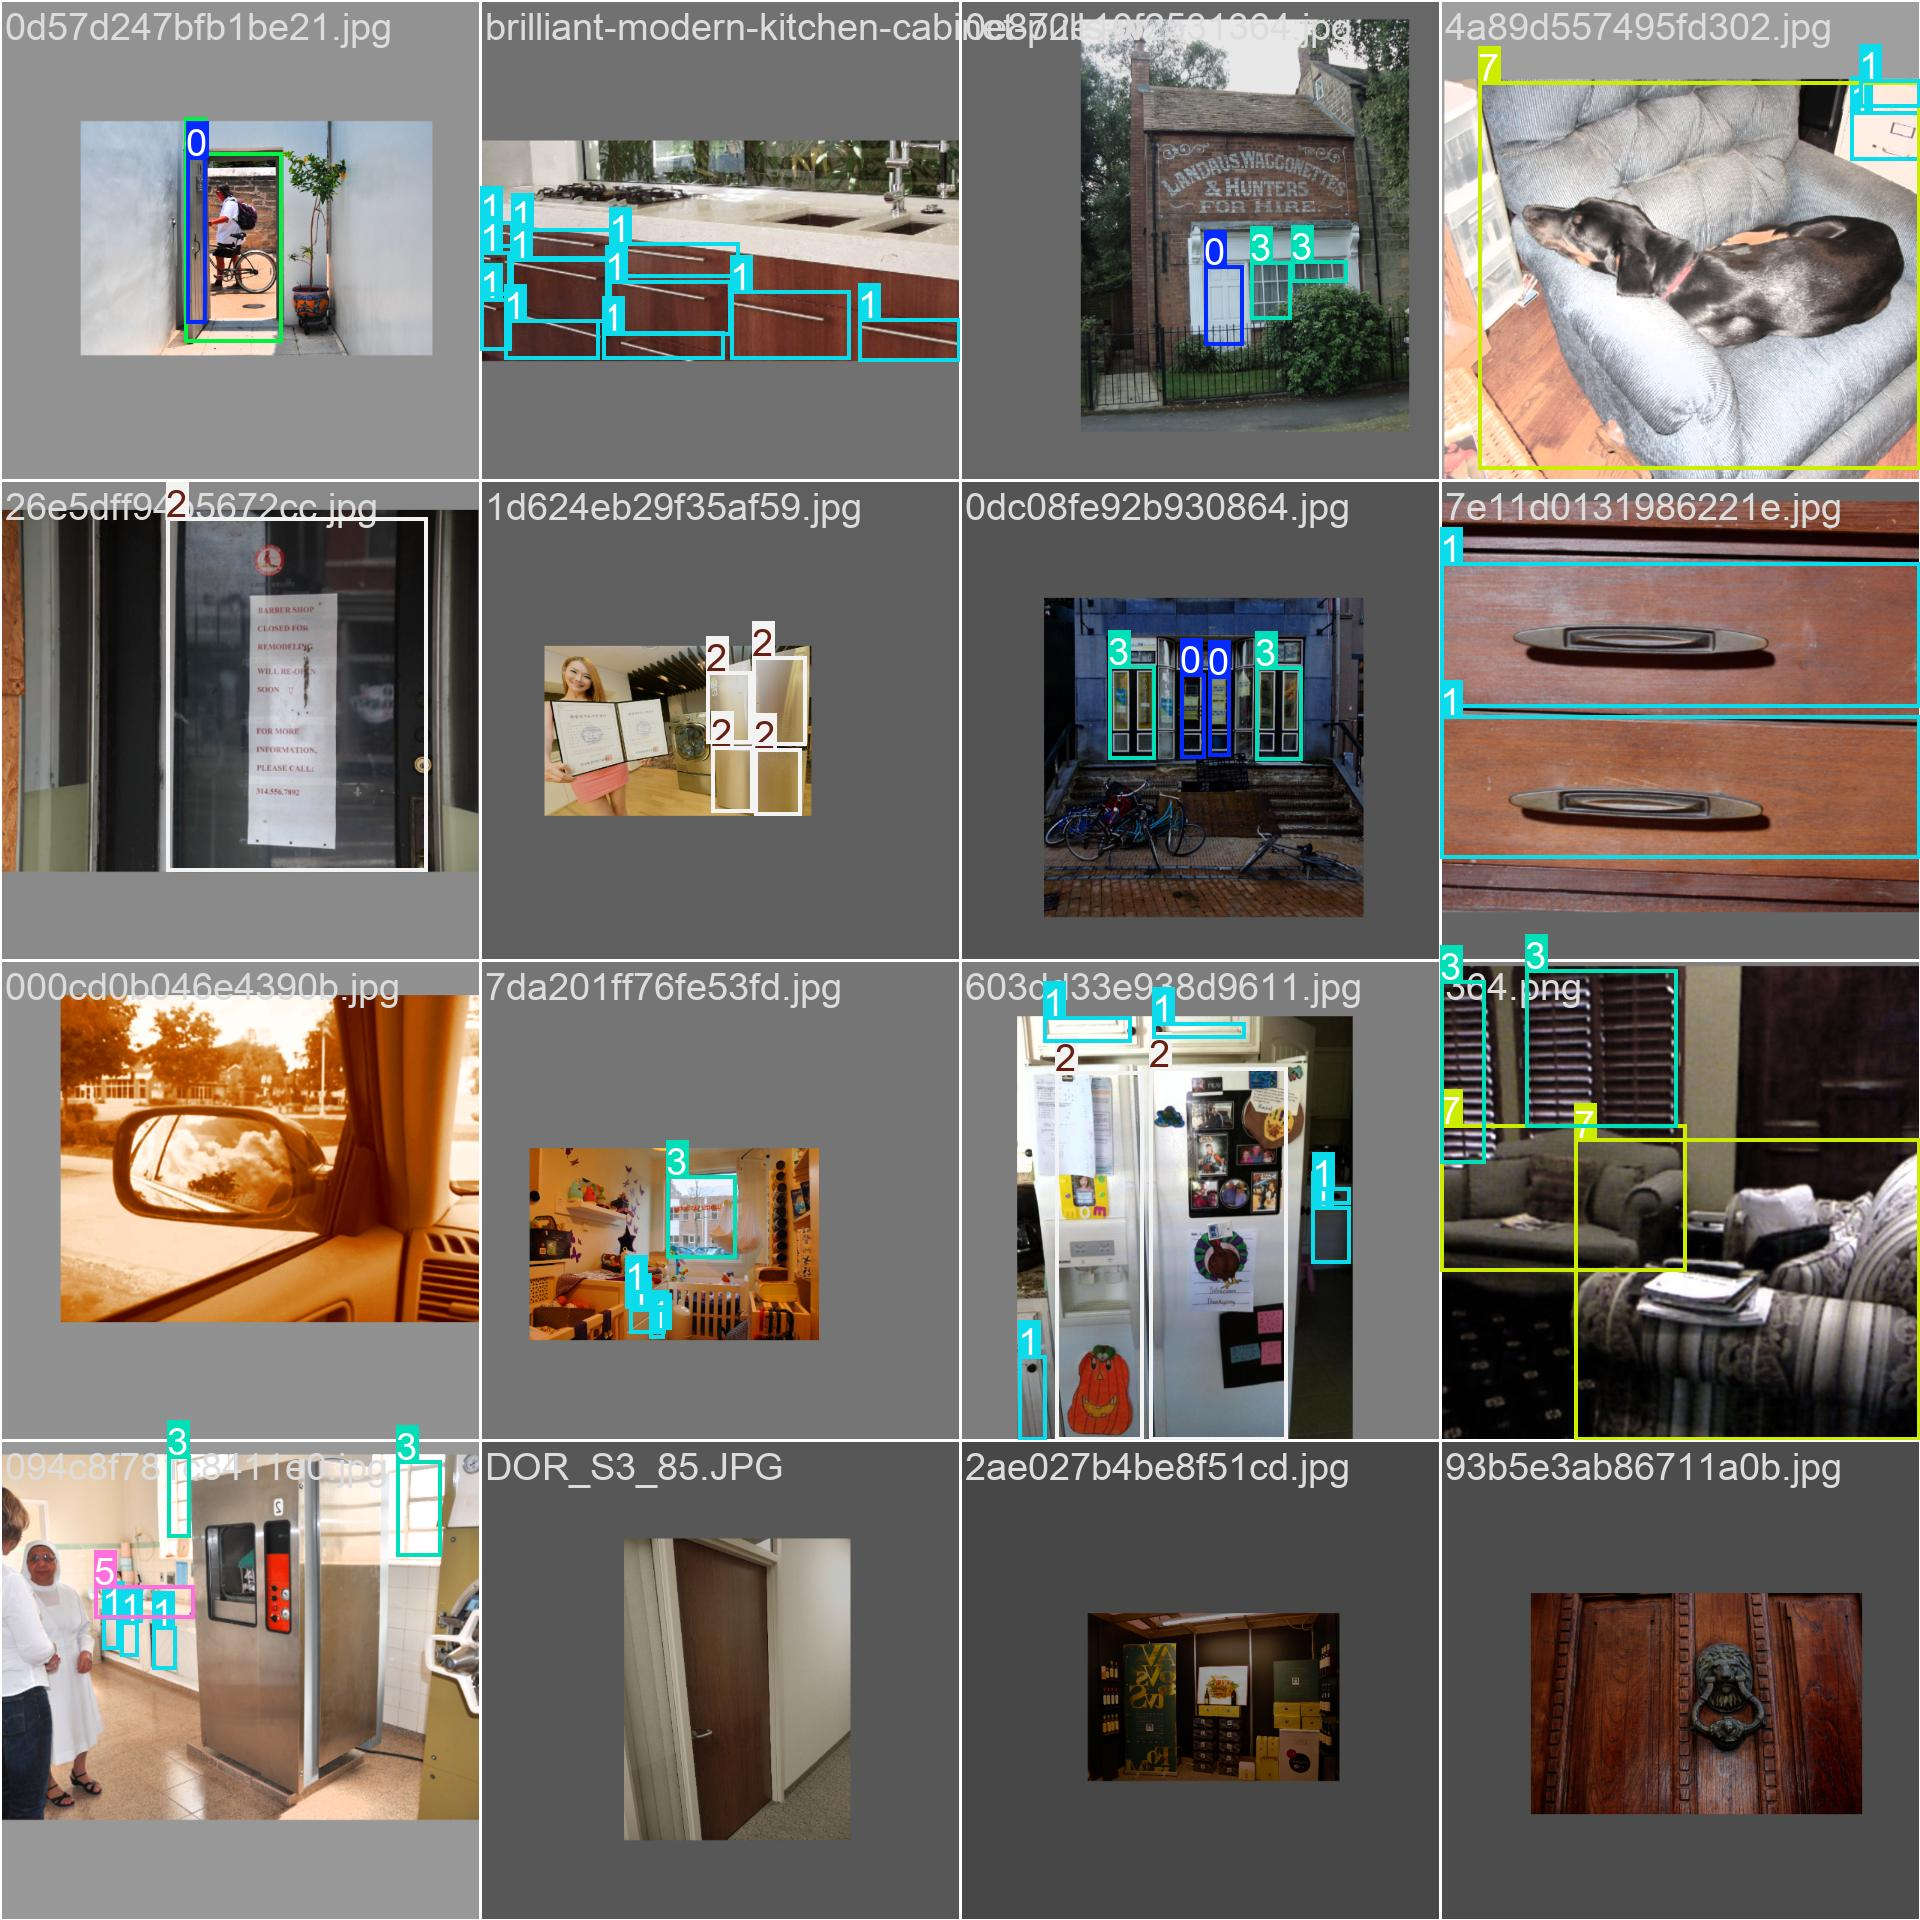

П.С. У LMS Буде додатково прикріплено файл роботи коду на локальній машині.